## <font color = 'Maroon'> Data Cleaning through NLP Parsing and EDA

In [457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import sqrt
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import requests
import warnings
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, plot_roc_curve, roc_curve, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings('ignore')

### <font color = 'Maroon'> Import Scraped Datasets, check duplicates, null values and retain necessary columns

In [458]:
dota_df = pd.read_csv('../datasets/dota.csv')
lol_df = pd.read_csv('../datasets/lol.csv')

In [459]:
#Ensure there are 4200 posts in each subreddit
print(dota_df.shape)
print(lol_df.shape)

(4199, 88)
(4199, 81)


We are going to check the uncleaned dota_df and lol_df, observed that there are lots of unnecessary columns. Here, we want to get the subreddit, selftext, title and created_utc, removed_by_category, is_self and is_video to analyse the texts

In [460]:
print(dota_df.columns)
print(lol_df.columns)

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'author',
       'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'author_fullname',
       'author_is_blocked', 'author_patreon_flair', 'author_premium',
       'awarders', 'banned_by', 'call_to_action', 'can_mod_post', 'category',
       'contest_mode', 'created_utc', 'crosspost_parent',
       'crosspost_parent_list', 'discussion_type', 'domain', 'full_link',
       'gallery_data', 'gildings', 'id', 'is_created_from_ads_ui',
       'is_crosspostable', 'is_gallery', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_ty

In [461]:
#Check for duplicates in dota_df
dota_df.duplicated().any()

False

In [462]:
#Check for duplicates in lol_df
lol_df.duplicated().any()

False

In [463]:
dota_df = dota_df[['author','subreddit', 'selftext', 'title', 'created_utc','removed_by_category', 'is_self','is_video']]
lol_df = lol_df[['author','subreddit', 'selftext', 'title', 'created_utc','removed_by_category', 'is_self', 'is_video']]

In [464]:
dota_df.head()

,author,subreddit,selftext,title,created_utc,removed_by_category,is_self,is_video
0,HoggiQQ,DotA2,"Hey, got a Saturday ticket for the Major in th...","Can't make it to the Major, giving away ticket.",1653116935,NaN,True,False
1,StartingFrom-273,DotA2,NaN,[Dota2]Eat some snacks. Don't miss the sights....,1653116783,NaN,False,False
2,lvndrs,DotA2,NaN,A TI in SEA is almost confirmed!,1653116690,NaN,False,False
3,tmjm,DotA2,"Hey,\n\nGot base model max studio (m1 max , 32...",M1 Mac crashing,1653115690,NaN,True,False
4,AnomaLuna,DotA2,NaN,Null Talisman meta is getting out of hand,1653115596,NaN,False,False


In [465]:
lol_df.head()

,author,subreddit,selftext,title,created_utc,removed_by_category,is_self,is_video
0,arisasam,leagueoflegends,[removed],My friend and I got fresh level 30 accts; afte...,1653117360,moderator,True,False
1,Massive_Dependent_63,leagueoflegends,So in my gold tier tokens I had death incarnat...,Question about tokens (the little badges you c...,1653117306,NaN,True,False
2,culaina001,leagueoflegends,NaN,Road to 1 month,1653117055,reddit,False,False
3,Mertcun,leagueoflegends,NaN,Any explain?,1653117019,NaN,False,True
4,SolubilityRules,leagueoflegends,"I'm a T1 fan, and I get it. The team dominated...",T1 members proclaiming victory even before get...,1653116857,NaN,True,False


In [466]:
#Check null values from each subreddit
dota_df.isnull().sum()

author                    0
subreddit                 0
selftext               1879
title                     0
created_utc               0
removed_by_category    3580
is_self                   0
is_video                  0
dtype: int64

In [467]:
lol_df.isnull().sum()

author                    0
subreddit                 0
selftext               1433
title                     0
created_utc               0
removed_by_category    2526
is_self                   0
is_video                  0
dtype: int64

There are quite a number of null selftext posts. However, those posts will be retained as it might contain important texts in title column. On the other hand, there are also a number of removed_by_category null values. It means those posts are not removed by reddit moderators. Therefore, they will be used as analysis instead. 

### <font color = 'Maroon'> Check proportion of removed_by_category

In [468]:
dota_lol_removed_by_category_df = pd.concat([dota_df, lol_df], axis=0)

In [469]:
dota_lol_removed_by_category_df['removed_by_category'] = dota_lol_removed_by_category_df['removed_by_category'].fillna('not removed')

In [470]:
dota_lol_removed_by_category_subreddit_gb = dota_lol_removed_by_category_df.groupby(by=['removed_by_category', 'subreddit'])
dota_lol_removed_by_category_subreddit_size = dota_lol_removed_by_category_subreddit_gb.size()

dota_lol_removed_by_category_gb = dota_lol_removed_by_category_df.groupby(by=['removed_by_category'])
dota_lol_removed_by_category_size = dota_lol_removed_by_category_gb.size()

removed_by_category_prop = dota_lol_removed_by_category_subreddit_size/dota_lol_removed_by_category_size
removed_by_category_prop = removed_by_category_prop.reset_index()
removed_by_category_prop.columns = ['removed_by_category', 'subreddit', 'Proportion']
removed_by_category_prop

,removed_by_category,subreddit,Proportion
0,automod_filtered,DotA2,0.397849
1,automod_filtered,leagueoflegends,0.602151
2,deleted,DotA2,0.340909
3,deleted,leagueoflegends,0.659091
4,moderator,DotA2,0.102810
5,moderator,leagueoflegends,0.897190
6,not removed,DotA2,0.586309
7,not removed,leagueoflegends,0.413691
8,reddit,DotA2,0.733813
9,reddit,leagueoflegends,0.266187


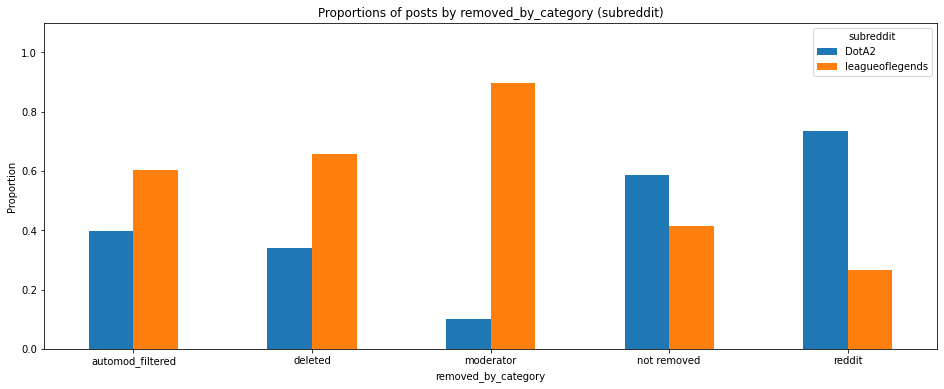

In [471]:
removed_by_category_pivot = pd.pivot_table(removed_by_category_prop, index = ['removed_by_category'], columns = ['subreddit'], values = 'Proportion')

removed_by_category_pivot.plot(kind = 'bar', rot = 0, figsize=(16,6), title="Proportions of posts by removed_by_category (subreddit)")
plt.xlabel('removed_by_category')
plt.ylabel('Proportion')
plt.ylim([0,1.1])
plt.show()

As the plot above, each subreddit post is filtered by automoderator, moderator and reddit platform itself. This is done to block posts that are inappropriate or contain harassing or evasive language. Also, the dataframe contains posts that are deleted by the author itself under 'deleted' category

It can be generally observed that there are more league of legends subreddit posts that are removed due to automods, moderator and deleted posts

In [472]:
dota_lol_removed_by_category_subreddit_flatten_df = dota_lol_removed_by_category_subreddit_gb.size().reset_index()
dota_lol_removed_by_category_subreddit_flatten_df.columns = ['removed_by_category', 'subreddit', 'No. of Posts']

dota_lol_removed_by_category_subreddit_pivot = pd.pivot_table(dota_lol_removed_by_category_subreddit_flatten_df, index=['removed_by_category'], columns=['subreddit'],
                                       values='No. of Posts', aggfunc=np.sum)
dota_lol_removed_by_category_subreddit_pivot.columns = dota_lol_removed_by_category_subreddit_pivot.columns.astype(str)
dota_lol_removed_by_category_subreddit_pivot.reset_index(inplace=True)
dota_lol_removed_by_category_subreddit_pivot.columns = ['removed_by_category', 'DotA2', 'leagueoflegends']

Text(0, 0.5, 'No. of Posts')

<Figure size 1440x504 with 0 Axes>

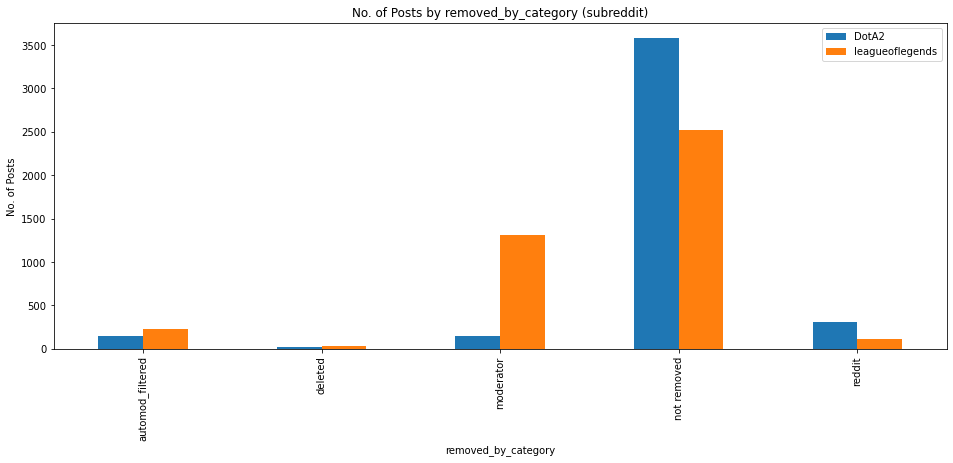

In [473]:
fig = plt.figure(figsize=(20, 7))

dota_lol_removed_by_category_subreddit_pivot.plot(kind='bar', x='removed_by_category',figsize=(16,6), title="No. of Posts by removed_by_category (subreddit)")
plt.ylabel('No. of Posts')

From the count plots, it can be seen that there are more Dota 2 posts that are not removed compared to league of legends posts

We will then proceed to only pick posts that are 'not removed'. Posts that are not removed are the ones with blank values in the original dataset

In [474]:
#Pick rows with nan values for removed_by_category. This only takes posts that are not removed in Reddit
dota_df = dota_df[dota_df['removed_by_category'].isna()]
lol_df = lol_df[lol_df['removed_by_category'].isna()]

In [475]:
print(dota_df.isnull().sum())
print(lol_df.isnull().sum())

author                    0
subreddit                 0
selftext               1647
title                     0
created_utc               0
removed_by_category    3580
is_self                   0
is_video                  0
dtype: int64
author                    0
subreddit                 0
selftext                633
title                     0
created_utc               0
removed_by_category    2526
is_self                   0
is_video                  0
dtype: int64


In [477]:
#Fill selftext null values with blanks as nan rows might contain important information from e.g. title
dota_df['selftext'] = dota_df['selftext'].fillna('')
lol_df['selftext'] = lol_df['selftext'].fillna('')

In [478]:
print(dota_df.isnull().sum())
print(lol_df.isnull().sum())

author                    0
subreddit                 0
selftext                  0
title                     0
created_utc               0
removed_by_category    3580
is_self                   0
is_video                  0
dtype: int64
author                    0
subreddit                 0
selftext                  0
title                     0
created_utc               0
removed_by_category    2526
is_self                   0
is_video                  0
dtype: int64


In [479]:
#Combine dota and lol df together
dota_lol_df = pd.concat([dota_df, lol_df], axis=0)
dota_lol_df['subreddit'].value_counts(normalize=True)

DotA2              0.586309
leagueoflegends    0.413691
Name: subreddit, dtype: float64

After removing removed posts from each subreddit, Dota2 consists of 59% of total data while LOL consists of 41% of total data. Slightly imbalanced but we can perform the cleaning and modelling first to check for the model score and decides if SMOTE is necessary

### <font color = 'Maroon'> Check empty selftext post counts by each subreddit

Text(0, 0.5, 'Post Count')

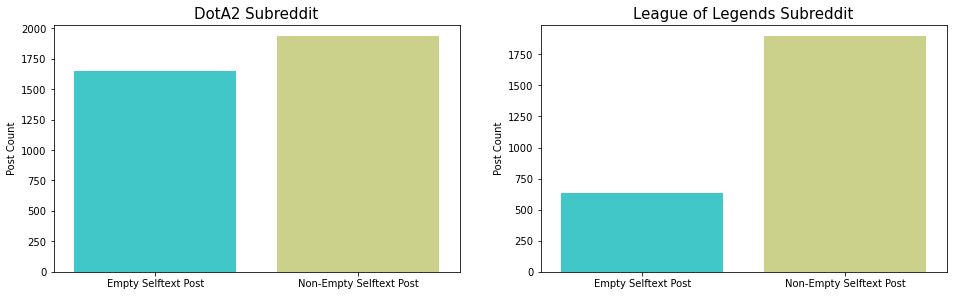

In [480]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

sns.countplot(x=dota_df['is_self'], order=[False, True], palette='rainbow', ax=ax1)
ax1.set_xticklabels(['Empty Selftext Post', 'Non-Empty Selftext Post'])
ax1.set_title('DotA2 Subreddit', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Post Count')

sns.countplot(x=lol_df['is_self'], order=[False, True], palette='rainbow', ax=ax2)
ax2.set_xticklabels(['Empty Selftext Post', 'Non-Empty Selftext Post'])
ax2.set_title('League of Legends Subreddit', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Post Count')

It can be seen that for both subreddits, there are more posts that contain text in the selftext. This is a good indicator as we have more texts to analyse for our model to predict the subreddit classification

Text(0, 0.5, 'Post Count')

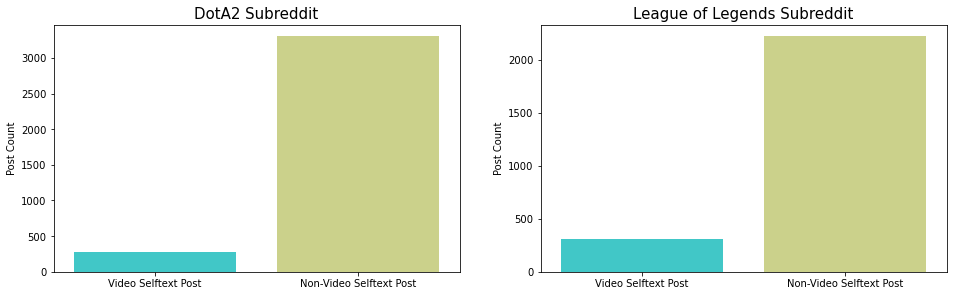

In [481]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

sns.countplot(x=dota_df['is_video'], order=[True, False], palette='rainbow', ax=ax1)
ax1.set_xticklabels(['Video Selftext Post', 'Non-Video Selftext Post'])
ax1.set_title('DotA2 Subreddit', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Post Count')

sns.countplot(x=lol_df['is_video'], order=[True, False], palette='rainbow', ax=ax2)
ax2.set_xticklabels(['Video Selftext Post', 'Non-Video Selftext Post'])
ax2.set_title('League of Legends Subreddit', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Post Count')

Also, there are more non-video selftext post in both subreddits. Both subreddits are good for NLP machine learning model.

In [482]:
#Retain only necessary columns
dota_lol_df = dota_lol_df[['author','subreddit', 'selftext', 'title', 'created_utc']]

In [483]:
dota_lol_df.tail()

,author,subreddit,selftext,title,created_utc
4183,ChappyChappman,leagueoflegends,,Friend gets instant karma for not waiting on m...,1652432667
4190,ChappyChappman,leagueoflegends,,"Well, first URF game was fun, Darius Penta",1652432360
4194,Jellanders,leagueoflegends,**[Urfbuilds](https://urfbuilds.com/all)**\n\n...,My friends and I built a website for URF build...,1652431340
4195,Turtleguy12345,leagueoflegends,This capsule dropped after the PSG Talon vs Fa...,New Esports Capsules Live,1652431116
4198,Missing42,leagueoflegends,I won a normal game and am barely over half on...,I did an oopsie and bought the event pass,1652430898


Above selftext and title will be used as our NLP texts to clean and analyse

## <font color = 'Maroon'> Cleaning the texts

### <font color = 'Maroon'> Create functions to remove text noise in selftext and title columns

Remove alphanumeric characters, http links, lower capital letters, remove trailing spaces and duplicated spaces, remove ampx and digits as well as remove punctuations.

In [485]:
def clean_names(remarks):
    remarks = " ".join(remarks.split())
    remarks = re.sub(r"http\S+", "", remarks)
    remarks = re.sub("[^0-9a-zA-Z\ ]", "", remarks)
    remarks = remarks.lower()
    remarks = remarks.strip()
    remarks = re.sub(r"\d+", "", remarks)
    remarks = re.sub(r"ampxb","", remarks)
    
    return remarks

In [486]:
dota_lol_df['selftext'] = dota_lol_df['selftext'].apply(clean_names)

In [488]:
def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

dota_lol_df['selftext_clean'] = dota_lol_df['selftext'].apply(lambda x: remove_punct(x))

In [489]:
dota_lol_df['title'] = dota_lol_df['title'].apply(clean_names)

In [490]:
dota_lol_df['title_clean'] = dota_lol_df['title'].apply(lambda x: remove_punct(x))

In [492]:
#Combine cleaned selftext and title together
dota_lol_df['selftext_title_cleaned'] = dota_lol_df['selftext_clean'] + ' ' + dota_lol_df['title_clean']

In [493]:
dota_lol_df.tail()

,author,subreddit,selftext,title,created_utc,selftext_clean,title_clean,selftext_title_cleaned
4183,ChappyChappman,leagueoflegends,,friend gets instant karma for not waiting on m...,1652432667,,friend gets instant karma for not waiting on m...,friend gets instant karma for not waiting on ...
4190,ChappyChappman,leagueoflegends,,well first urf game was fun darius penta,1652432360,,well first urf game was fun darius penta,well first urf game was fun darius penta
4194,Jellanders,leagueoflegends,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,1652431340,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,urfbuilds hey everyone my friends and i built ...
4195,Turtleguy12345,leagueoflegends,this capsule dropped after the psg talon vs fa...,new esports capsules live,1652431116,this capsule dropped after the psg talon vs fa...,new esports capsules live,this capsule dropped after the psg talon vs fa...
4198,Missing42,leagueoflegends,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,1652430898,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,i won a normal game and am barely over half on...


### <font color = 'Maroon'> Tokenize words

In [494]:
#Tokenize each word in selftext_title_cleaned
def tokenize(text):
    tokenized = word_tokenize(text)
    return tokenized

dota_lol_df['selftext_title_tokenized'] = dota_lol_df['selftext_title_cleaned'].apply(lambda x: tokenize(x))

dota_lol_df.tail()

,author,subreddit,selftext,title,created_utc,selftext_clean,title_clean,selftext_title_cleaned,selftext_title_tokenized
4183,ChappyChappman,leagueoflegends,,friend gets instant karma for not waiting on m...,1652432667,,friend gets instant karma for not waiting on m...,friend gets instant karma for not waiting on ...,"[friend, gets, instant, karma, for, not, waiti..."
4190,ChappyChappman,leagueoflegends,,well first urf game was fun darius penta,1652432360,,well first urf game was fun darius penta,well first urf game was fun darius penta,"[well, first, urf, game, was, fun, darius, penta]"
4194,Jellanders,leagueoflegends,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,1652431340,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,urfbuilds hey everyone my friends and i built ...,"[urfbuilds, hey, everyone, my, friends, and, i..."
4195,Turtleguy12345,leagueoflegends,this capsule dropped after the psg talon vs fa...,new esports capsules live,1652431116,this capsule dropped after the psg talon vs fa...,new esports capsules live,this capsule dropped after the psg talon vs fa...,"[this, capsule, dropped, after, the, psg, talo..."
4198,Missing42,leagueoflegends,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,1652430898,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,i won a normal game and am barely over half on...,"[i, won, a, normal, game, and, am, barely, ove..."


### <font color = 'Maroon'> Remove Stop words

In [495]:
STOP_WORDS = stopwords.words('english')

def remove_stopwords(tokenized_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in STOP_WORDS]
    return text

dota_lol_df['selftext_title_cleaned_tokenized_stopwords'] = dota_lol_df['selftext_title_tokenized'].apply(remove_stopwords)
dota_lol_df.tail()

,author,subreddit,selftext,title,created_utc,selftext_clean,title_clean,selftext_title_cleaned,selftext_title_tokenized,selftext_title_cleaned_tokenized_stopwords
4183,ChappyChappman,leagueoflegends,,friend gets instant karma for not waiting on m...,1652432667,,friend gets instant karma for not waiting on m...,friend gets instant karma for not waiting on ...,"[friend, gets, instant, karma, for, not, waiti...","[friend, gets, instant, karma, waiting, plant]"
4190,ChappyChappman,leagueoflegends,,well first urf game was fun darius penta,1652432360,,well first urf game was fun darius penta,well first urf game was fun darius penta,"[well, first, urf, game, was, fun, darius, penta]","[well, first, urf, game, fun, darius, penta]"
4194,Jellanders,leagueoflegends,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,1652431340,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,urfbuilds hey everyone my friends and i built ...,"[urfbuilds, hey, everyone, my, friends, and, i...","[urfbuilds, hey, everyone, friends, built, nic..."
4195,Turtleguy12345,leagueoflegends,this capsule dropped after the psg talon vs fa...,new esports capsules live,1652431116,this capsule dropped after the psg talon vs fa...,new esports capsules live,this capsule dropped after the psg talon vs fa...,"[this, capsule, dropped, after, the, psg, talo...","[capsule, dropped, psg, talon, vs, fastpay, wi..."
4198,Missing42,leagueoflegends,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,1652430898,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,i won a normal game and am barely over half on...,"[i, won, a, normal, game, and, am, barely, ove...","[normal, game, barely, half, way, earn, tokens..."


Checked that the words have been tokenized and stop words removed, I proceed to try both stemming and lemmatization and compare their distributions of words for each method

### <font color = 'Maroon'> Stemming

In [496]:
stemmer = PorterStemmer()

def word_stem(x):
    text = [stemmer.stem(word) for word in x]
    return text

dota_lol_df['selftext_title_cleaned_stemmed'] = dota_lol_df['selftext_title_cleaned_tokenized_stopwords'].apply(lambda x: word_stem(x))

dota_lol_df.tail()

,author,subreddit,selftext,title,created_utc,selftext_clean,title_clean,selftext_title_cleaned,selftext_title_tokenized,selftext_title_cleaned_tokenized_stopwords,selftext_title_cleaned_stemmed
4183,ChappyChappman,leagueoflegends,,friend gets instant karma for not waiting on m...,1652432667,,friend gets instant karma for not waiting on m...,friend gets instant karma for not waiting on ...,"[friend, gets, instant, karma, for, not, waiti...","[friend, gets, instant, karma, waiting, plant]","[friend, get, instant, karma, wait, plant]"
4190,ChappyChappman,leagueoflegends,,well first urf game was fun darius penta,1652432360,,well first urf game was fun darius penta,well first urf game was fun darius penta,"[well, first, urf, game, was, fun, darius, penta]","[well, first, urf, game, fun, darius, penta]","[well, first, urf, game, fun, dariu, penta]"
4194,Jellanders,leagueoflegends,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,1652431340,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,urfbuilds hey everyone my friends and i built ...,"[urfbuilds, hey, everyone, my, friends, and, i...","[urfbuilds, hey, everyone, friends, built, nic...","[urfbuild, hey, everyon, friend, built, nice, ..."
4195,Turtleguy12345,leagueoflegends,this capsule dropped after the psg talon vs fa...,new esports capsules live,1652431116,this capsule dropped after the psg talon vs fa...,new esports capsules live,this capsule dropped after the psg talon vs fa...,"[this, capsule, dropped, after, the, psg, talo...","[capsule, dropped, psg, talon, vs, fastpay, wi...","[capsul, drop, psg, talon, vs, fastpay, wildca..."
4198,Missing42,leagueoflegends,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,1652430898,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,i won a normal game and am barely over half on...,"[i, won, a, normal, game, and, am, barely, ove...","[normal, game, barely, half, way, earn, tokens...","[normal, game, bare, half, way, earn, token, p..."


### <font color = 'Maroon'> Lemmatizing

In [497]:
lemmatizer = nltk.WordNetLemmatizer()

In [498]:
def word_lemmatize(x):
    # return list of all lemmatized words for their corresponding words in tokenized_text
    text = [lemmatizer.lemmatize(word) for word in x]
    return text

dota_lol_df['selftext_title_cleaned_lemmatized'] = dota_lol_df['selftext_title_cleaned_tokenized_stopwords'].apply(lambda x: word_lemmatize(x))

dota_lol_df.tail()

,author,subreddit,selftext,title,created_utc,selftext_clean,title_clean,selftext_title_cleaned,selftext_title_tokenized,selftext_title_cleaned_tokenized_stopwords,selftext_title_cleaned_stemmed,selftext_title_cleaned_lemmatized
4183,ChappyChappman,leagueoflegends,,friend gets instant karma for not waiting on m...,1652432667,,friend gets instant karma for not waiting on m...,friend gets instant karma for not waiting on ...,"[friend, gets, instant, karma, for, not, waiti...","[friend, gets, instant, karma, waiting, plant]","[friend, get, instant, karma, wait, plant]","[friend, get, instant, karma, waiting, plant]"
4190,ChappyChappman,leagueoflegends,,well first urf game was fun darius penta,1652432360,,well first urf game was fun darius penta,well first urf game was fun darius penta,"[well, first, urf, game, was, fun, darius, penta]","[well, first, urf, game, fun, darius, penta]","[well, first, urf, game, fun, dariu, penta]","[well, first, urf, game, fun, darius, penta]"
4194,Jellanders,leagueoflegends,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,1652431340,urfbuilds hey everyone my friends and i built ...,my friends and i built a website for urf build...,urfbuilds hey everyone my friends and i built ...,"[urfbuilds, hey, everyone, my, friends, and, i...","[urfbuilds, hey, everyone, friends, built, nic...","[urfbuild, hey, everyon, friend, built, nice, ...","[urfbuilds, hey, everyone, friend, built, nice..."
4195,Turtleguy12345,leagueoflegends,this capsule dropped after the psg talon vs fa...,new esports capsules live,1652431116,this capsule dropped after the psg talon vs fa...,new esports capsules live,this capsule dropped after the psg talon vs fa...,"[this, capsule, dropped, after, the, psg, talo...","[capsule, dropped, psg, talon, vs, fastpay, wi...","[capsul, drop, psg, talon, vs, fastpay, wildca...","[capsule, dropped, psg, talon, v, fastpay, wil..."
4198,Missing42,leagueoflegends,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,1652430898,i won a normal game and am barely over half on...,i did an oopsie and bought the event pass,i won a normal game and am barely over half on...,"[i, won, a, normal, game, and, am, barely, ove...","[normal, game, barely, half, way, earn, tokens...","[normal, game, bare, half, way, earn, token, p...","[normal, game, barely, half, way, earn, token,..."


### <font color = 'Maroon'> Join Tokenized Sentences as strings for NLP model feeding

In [499]:
dota_lol_df['title_selftext_stemmed_joined'] = dota_lol_df['selftext_title_cleaned_stemmed'].apply(lambda x: ' '.join(map(str, x)))
dota_lol_df['title_selftext_lemmed_joined'] = dota_lol_df['selftext_title_cleaned_lemmatized'].apply(lambda x: ' '.join(map(str, x)))
dota_lol_df = dota_lol_df.fillna('')
dota_lol_df['title_selftext_stemmed_joined']
dota_lol_df['title_selftext_lemmed_joined']

0       hey got saturday ticket major aa section grab ...
1       dotaeat snack dont miss sight youll find way f...
2                                 ti sea almost confirmed
3       hey got base model max studio max gb ram somet...
4                         null talisman meta getting hand
                              ...                        
4183               friend get instant karma waiting plant
4190                 well first urf game fun darius penta
4194    urfbuilds hey everyone friend built nice websi...
4195    capsule dropped psg talon v fastpay wildcat gu...
4198    normal game barely half way earn token past wo...
Name: title_selftext_lemmed_joined, Length: 6106, dtype: object

### <font color = 'Maroon'> Getting distribution plot of DotA2 vs League of Legends

In [500]:
#Getting the word counts of tokenized words for word stem
dota_lol_df['stemmed_len'] = dota_lol_df['selftext_title_cleaned_stemmed'].apply(lambda x:len(x))

Text(0, 0.5, '% of')

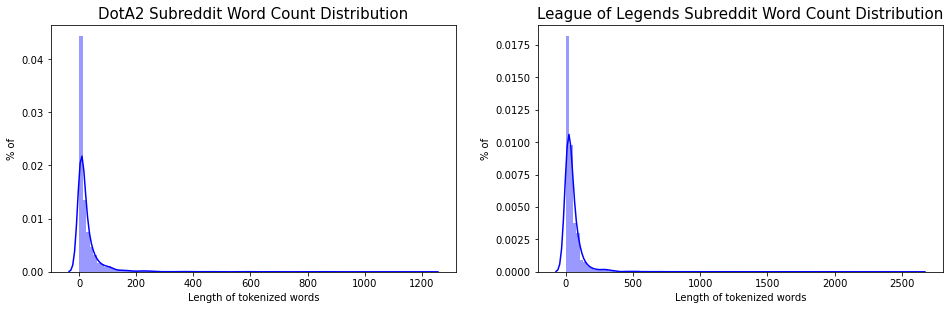

In [501]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

sns.distplot(x=dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['stemmed_len'],  bins = 100, color= 'blue', ax=ax1)
ax1.set_title('DotA2 Subreddit Word Count Distribution', fontsize=15)
ax1.set_xlabel('Length of tokenized words')
ax1.set_ylabel('% of')

sns.distplot(x=dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['stemmed_len'], bins = 100, color= 'blue', ax=ax2)
ax2.set_title('League of Legends Subreddit Word Count Distribution', fontsize=15)
ax2.set_xlabel('Length of tokenized words')
ax2.set_ylabel('% of')

Both subreddits have right-skewed distribution, suggesting that majority of the rows have relatively small word counts. There are outliers identified in the amount of words. We'll proceed to plot box plots to identify the outliers  

Text(0, 0.5, 'Word Count')

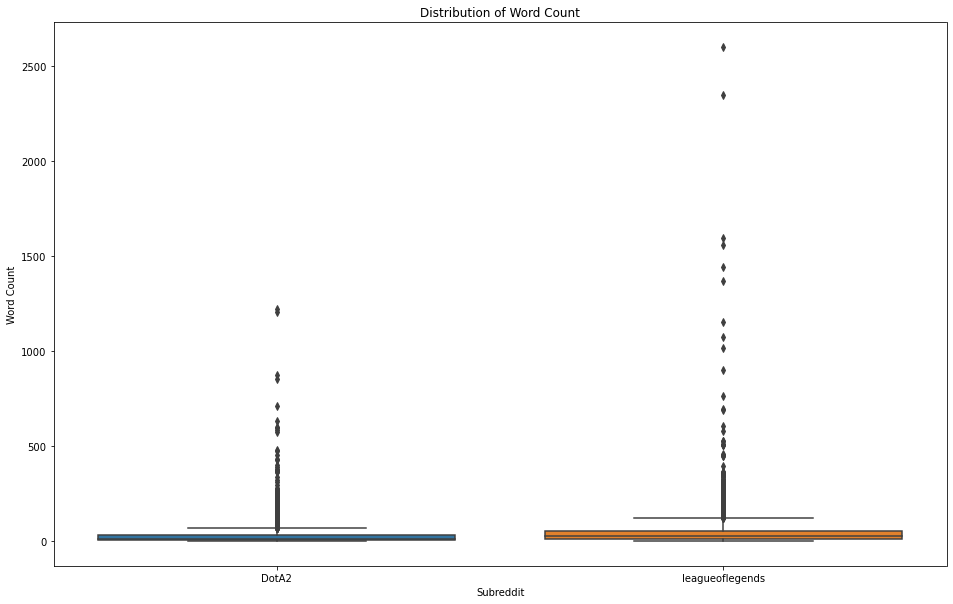

In [502]:
fig = plt.figure(figsize=(16,10))

boxplot_subreddit = sns.boxplot(x= 'subreddit' ,y = 'stemmed_len' , orient ='v',data = dota_lol_df)
boxplot_subreddit.axes.set_title('Distribution of Word Count')
boxplot_subreddit.set_xlabel('Subreddit')
boxplot_subreddit.set_ylabel('Word Count')

Since posts with > 250 word counts are outliers, we'll check those posts and see if it's worth to be dropped. 

In [503]:
#Check if posts with > 250 word counts are needed to be dropped
print(dota_lol_df[dota_lol_df['stemmed_len'] > 250]['selftext_title_cleaned'])

#Used code below to get the full list of words. Since the print result is too long, i do not include the list in this notebook
#dota_lol_df[dota_lol_df['stemmed_len'] > 250]['selftext_title_cleaned'].apply(print)

7       watch video guide here fantasy video guide for...
57      tldr sort each table by the expectation exp co...
326     tldr sort each table by the expectation exp co...
659     tldr sort each table by the expectation exp co...
860     tldr sort each table by the expectation exp co...
                              ...                        
3642    msi   group stage lolesports  leaguepedia  eve...
3670    let me list two reasons  we can have quarterfi...
3747    tldr there is a bunch of different teams that ...
4038    i am  convinced this is true before i continue...
4109    well first of all i started playing league a y...
Name: selftext_title_cleaned, Length: 106, dtype: object


Outliers posts contain important keywords. Therefore, outliers post will be preserved for analysis

### <font color = 'Maroon'> Visualise Frequently Occuring Words (First Round)

In [504]:
#Getting function to plot bar charts
def word_count_plotter(df1, df2, title=""):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title, y=0.98, fontsize = 20)

    plot1 = df1.plot(kind='barh', y='value', x='feature_names', fontsize = 15, ax=axes[0], figsize=(12,10), color='green');
    plot1.set_xlabel('Count', fontsize=15)
    plot1.set_ylabel('Words', fontsize=15)
    plot1.set_title('DotA 2', fontsize=17)
    
    plot2 = df2.plot(kind='barh', y='value', x='feature_names', fontsize= 15, ax=axes[1], figsize=(12,10),color='blue');

    plot2.set_xlabel('Count', fontsize=15)
    plot2.set_ylabel('Words', fontsize=15)
    plot2.set_title('League of Legends', fontsize=17)

    plt.subplots_adjust(wspace=1)
    plt.show()

#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (Count Vectorizer - 1 gram)

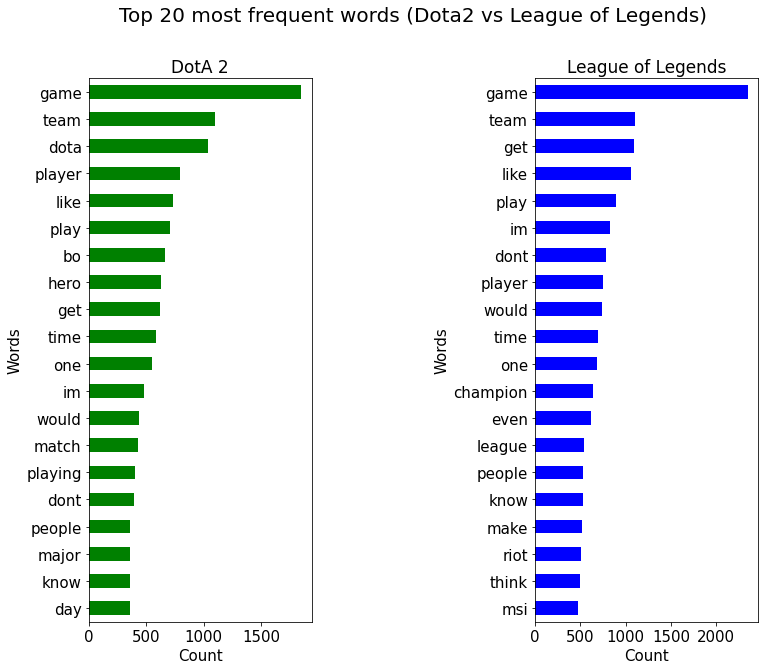

In [505]:
#Count Vectorizer with 1-gram

onegram_vect = CountVectorizer(ngram_range=(1,1))

dota_onegram_vect_lem_df = pd.DataFrame(onegram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= onegram_vect.get_feature_names())

lol_onegram_vect_lem_df = pd.DataFrame(onegram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= onegram_vect.get_feature_names())

word_count_plotter(dota_onegram_vect_lem_df.sum().sort_values(ascending=True).tail(20), lol_onegram_vect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent words (Dota2 vs League of Legends)")

From the plot above, there are still a lot of stop words that need to be eliminated from each subreddit e.g. im, would, bo, even, etc. We'll then proceed to use 2-grams count vectorizer before removing those extra stop words

#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (Count Vectorizer - 2 grams)

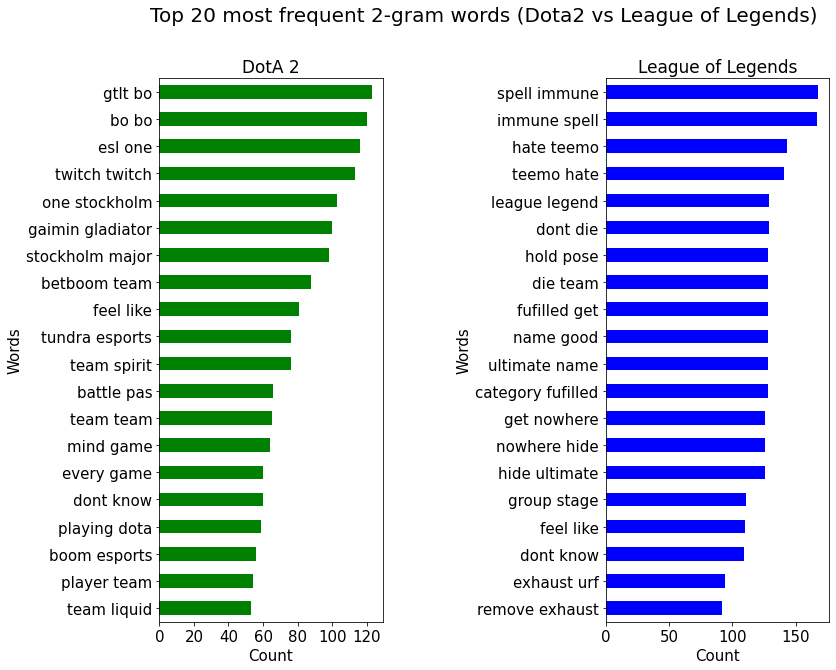

In [506]:
#Count Vectorizer with 2-gram
twogram_vect = CountVectorizer(ngram_range=(2,2))

dota_twogram_vect_lem_df = pd.DataFrame(twogram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= twogram_vect.get_feature_names())

lol_twogram_vect_lem_df = pd.DataFrame(twogram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= twogram_vect.get_feature_names())

word_count_plotter(dota_twogram_vect_lem_df.sum().sort_values(ascending=True).tail(20), lol_twogram_vect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent 2-gram words (Dota2 vs League of Legends)")

Using the 2-grams method on Count Vectorizer, there are also lots of unnecessary stopwords, e.g. bo bo, gtlt bob, etc. We'll remove extra stopwords later on

#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (TFIDF vectorizer - 1 gram)

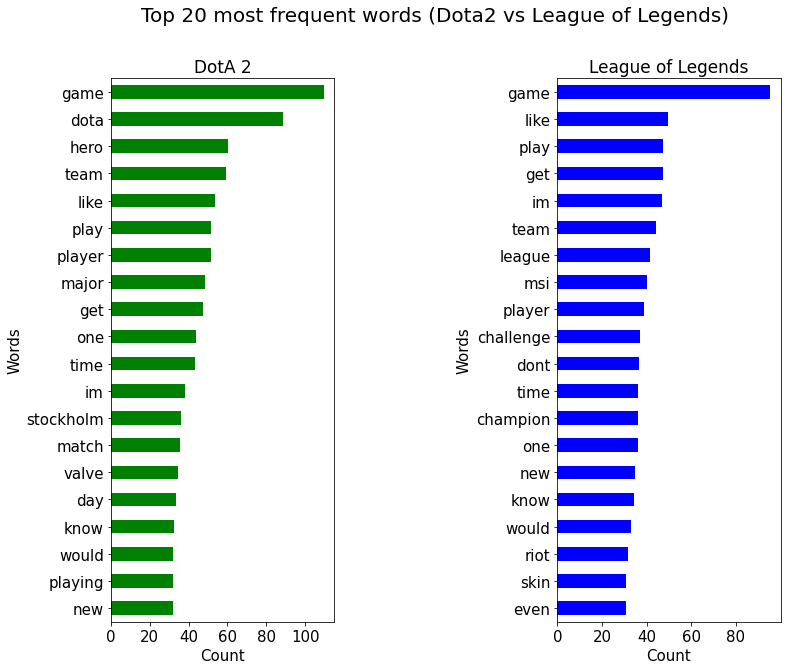

In [507]:
#TFidf Vectorizer with 1-gram
tfidf_vect = TfidfVectorizer(ngram_range=(1,1))

dota_onegram_tfidfvect_lem_df = pd.DataFrame(tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= tfidf_vect.get_feature_names())

lol_onegram_tfidfvect_lem_df = pd.DataFrame(tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= tfidf_vect.get_feature_names())

word_count_plotter(dota_onegram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), lol_onegram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent words (Dota2 vs League of Legends)")

Similarly for Tfid Vectorizer method, there are stop words that need to be eliminated as well, e.g. im, get, would, game, etc

#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (TFIDF vectorizer - 2 grams)

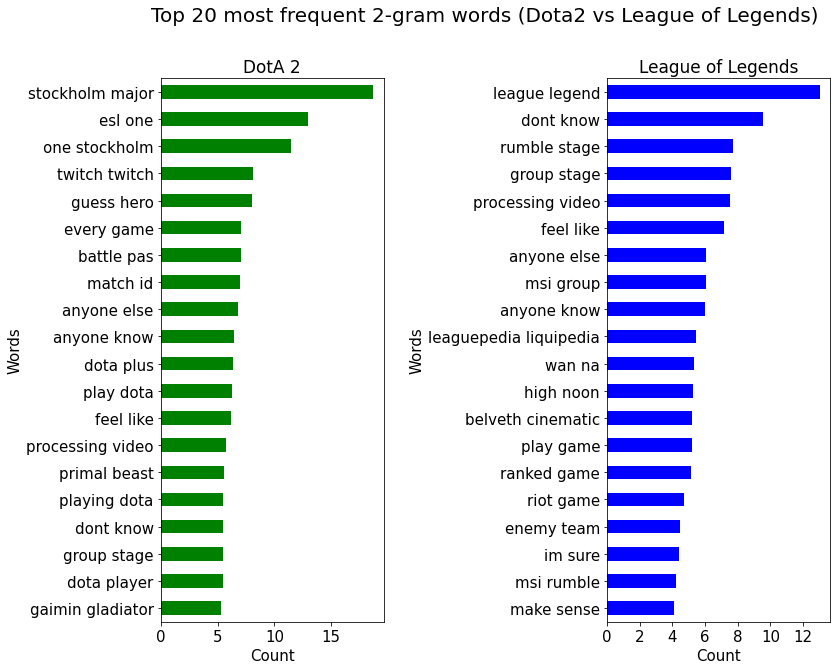

In [508]:
#TFidf Vectorizer with 2-grams
twogram_tfidf_vect = TfidfVectorizer(ngram_range=(2,2))

dota_twogram_tfidfvect_lem_df = pd.DataFrame(twogram_tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= twogram_tfidf_vect.get_feature_names())

lol_twogram_tfidfvect_lem_df = pd.DataFrame(twogram_tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= twogram_tfidf_vect.get_feature_names())

word_count_plotter(dota_twogram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), lol_twogram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent 2-gram words (Dota2 vs League of Legends)")

For Tfid 2-gram Tfid Vectorizer, stop words e.g. dont know, wan na,etc need to be removed. Those stop words will be removed.

Surprisingly, none of the heroes from each subreddit are in the top frequent word lists for both Count Vectorizer and Tfid Vectorizer (1-gram and 2-grams)

### <font color = 'Maroon'> Removing Extra Stop Words and Visualize final round

In [509]:
stopwords_update = ['game','dota', 'like','even','team', 'player', 'people','know','dont','match','playing','im','would','one','bo',
                  'get','guy','something','year','every','please','anyone','see','much',
                  'good','really',' back','cant','win','it','got','account','still','want','think','also','support',
                  'make','item','day','win','first','year','enemy','thing','day','feel','could','top','every','go','got',
                  'damage','also','skin','good','playing','make','know','people','even','get', 'need', 'played', 
                  'way', 'anyone', 'back', 'it', 'new', 'players', 'play', 'lane', 'group', 'server', 'change',
                  'fix','guide','id','guy','last','patch','bug','lp','video','level','ive','someone','chat','skin','ranked',
                  'games', 'getting', 'going', 'say', 'help', 'mid', 'rank', 'never', 'give', 'best', 'guy', 'something',
                  'issue', 'client', 'post', 'getting', 'skins', 'guess', 'update', 'po', 'guys', 'bad', 'stage', 'else',
                  'teams','fun','find','carry','guy', 'screen','right','doesnt','friend', 'work', 'made', 'main', 'point', 
                  'love', 'year', 'reason', 'high', 'many', 'better', 'ever', 'come', 'years', 'today', 'thought', 'next', 'kills', 'sea',
                  'anything','everyone', 'na', 'kill', 'take', 'pro', 'report', 'second', 'idea', 'banned', 'pick', 'end', 'lot', 'well', 
                  'look', 'looking', 'problem', 'looking', 'didnt', 'start', 'literally', 'eg', 'title', 'maybe', 'month', 'hard', 'use',
                  'question', 'weeks', 'always', 'two', 'around', 'week', 'twitch', 'already', 'queue', 'watch', 'trying', 'og',
                  'role', 'clash', 'true', 'ban', 'actually', 'tell', 'show', 'event', 'skill', 'without', 'able', 'let', 'sure',
                  'score', 'pas', 'try', 'ago','min', 'old', 'ward', 'different', 'pretty', 'mean', 'hope', 'minute', 'season',
                  'reward', 'battle', 'jungle', 'thanks', 'keep', 'played','gtlt', 'gets', 'since', 'lol', 'may', 'name', 'urf', 'thats', 'time', 'champs', 'champion', 'champions', 'challenge'] 

def remove_extra_stopwords(tokenized_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopwords_update]
    return text

dota_lol_df['selftext_title_cleaned_tokenized_stopwords'] = dota_lol_df['selftext_title_cleaned_tokenized_stopwords'].apply(remove_extra_stopwords)

In [511]:
#Repeat previous steps: Stemming and Lemmatizing
dota_lol_df['selftext_title_cleaned_stemmed'] = dota_lol_df['selftext_title_cleaned_tokenized_stopwords'].apply(lambda x: word_stem(x))
dota_lol_df['selftext_title_cleaned_lemmatized'] = dota_lol_df['selftext_title_cleaned_tokenized_stopwords'].apply(lambda x: word_lemmatize(x))

In [512]:
#Repeat previous steps: Join Tokenized Sentences
dota_lol_df['title_selftext_stemmed_joined'] = dota_lol_df['selftext_title_cleaned_stemmed'].apply(lambda x: ' '.join(map(str, x)))
dota_lol_df['title_selftext_lemmed_joined'] = dota_lol_df['selftext_title_cleaned_lemmatized'].apply(lambda x: ' '.join(map(str, x)))
dota_lol_df = dota_lol_df.fillna('')

False

In [513]:
#Getting the length of tokenized words for word stem
dota_lol_df['stemmed_len'] = dota_lol_df['selftext_title_cleaned_stemmed'].apply(lambda x:len(x))

Text(0, 0.5, 'Word Count')

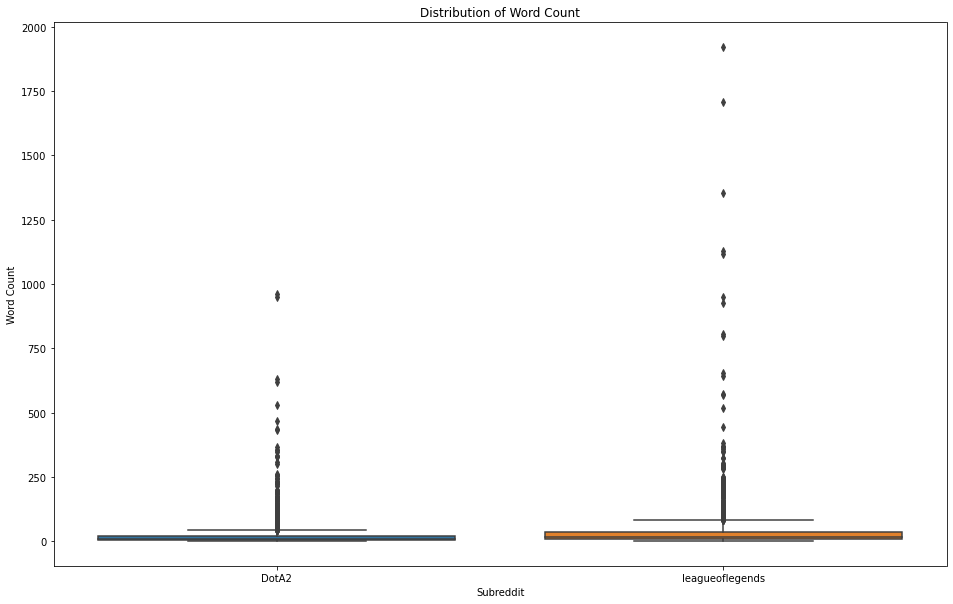

In [514]:
fig = plt.figure(figsize=(16,10))

boxplot_subreddit = sns.boxplot(x= 'subreddit' ,y = 'stemmed_len' , orient ='v',data = dota_lol_df)
boxplot_subreddit.axes.set_title('Distribution of Word Count')
boxplot_subreddit.set_xlabel('Subreddit')
boxplot_subreddit.set_ylabel('Word Count')

Similar to previous steps, we'll keep outliers as those posts contain important keyword

#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (Count Vectorizer - 1 gram)

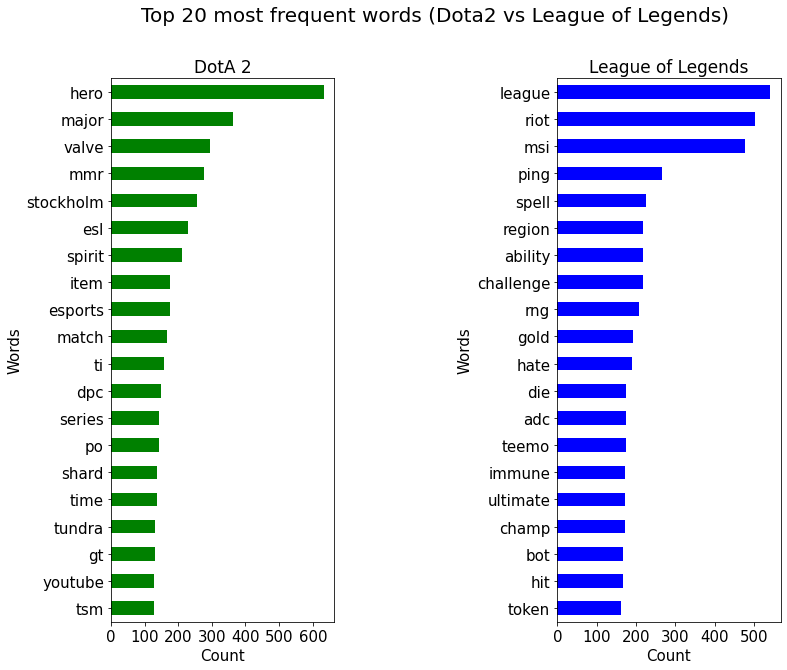

In [515]:
#Count Vectorizer with 1-gram

onegram_vect = CountVectorizer(ngram_range=(1,1))

dota_onegram_vect_lem_df = pd.DataFrame(onegram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= onegram_vect.get_feature_names())

lol_onegram_vect_lem_df = pd.DataFrame(onegram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= onegram_vect.get_feature_names())

word_count_plotter(dota_onegram_vect_lem_df.sum().sort_values(ascending=True).tail(20), lol_onegram_vect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent words (Dota2 vs League of Legends)")

After removing extra stopwords, those are a few observations:


Dota2 subreddit
- Subreddit generally centers around tournaments, as seen from the word Stockholm, referring to ESL one in Stockholm happened 12 May -22 May 2022
- Also, TI(The International) and DPC (Dota Pro Circuit) refer to the top tournaments and placements for top teams
- MMRs are also the top words as people talk about their own ranked matches or pro players rank matches


League of Legends subreddit
- Subreddit centers around gameplay and game highlights as people talk about ability, challenge, spell , ultimate.
- The community talks a bit of strategy as shown in the word adc (Attack Damage Carry) and bot (Bottom lane)
- Only MSI ( Mid-Season Invitational) competition is in the frequent word, unlike Dota2 with many competitions in the word list

Both games publisher (Valve for Dota2 and Riot for League of Legends) are in the top words list which is expected.

Surprisingly, only a small portion of characters name from each game are mentioned.
- For Dota2, only 'spirit' is mentioned. However, 'spirit' can refer to 4 heroes e.g. 'Ember Spirit', 'Void Spirit', 'Storm Spirit' , 'Earth Spirit' and 'Spirit Breaker'. Those words will be analysed later in 2-grams vectorizer to see if they are in the list
- For League of Legends, only teemo is mentioned in the list.

#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (Count Vectorizer - 2 grams)

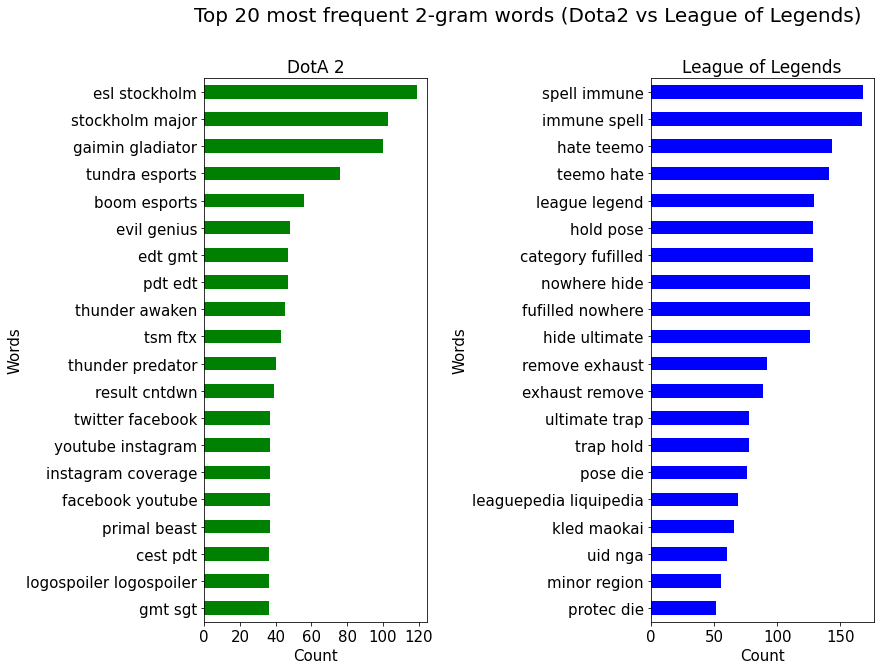

In [520]:
#Count Vectorizer with 2-gram
twogram_vect = CountVectorizer(ngram_range=(2,2))

dota_twogram_vect_lem_df = pd.DataFrame(twogram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= twogram_vect.get_feature_names())

lol_twogram_vect_lem_df = pd.DataFrame(twogram_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= twogram_vect.get_feature_names())

word_count_plotter(dota_twogram_vect_lem_df.sum().sort_values(ascending=True).tail(20), lol_twogram_vect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent 2-gram words (Dota2 vs League of Legends)")

Observations:


DotA2 subreddit

- Similar to 1-gram, Dota2 subreddit focuses on competition talks (ESL Stockholm and Stockholm Majors). With 2-grams vectorizer, more esports teams are mentioned, such as:
    1. Gaimin Gladiator
    2. Tundra Esports
    3. Boom Esports
    4. Evil Genius
    5. TSM FTX
- Several time zones are also mentioned in the top list. However, as digits are removed through data cleaning, the time zones are next to each other.
- Social media coverage (instagram facebook youtube) are mentioned as part of competition coverage
- Primal Beast is a hero that was recently launched by Dota2 (2022 23rd Feb). As it is a newborn hero, this hero is still a hot topic
- None of the heroes containing 'spirit' is in the list, indicating either those heroes are not popularly mentioned in the subreddit


League of Legends subreddit

- Similar to 1-gram, League of Legends subreddit focuses on gameplay through spell immune, hide ultimate, remove exhaust
- Head to head top lane heroes (Kled and Maokai) are often being discussed


#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (TFIDF - 1 gram)

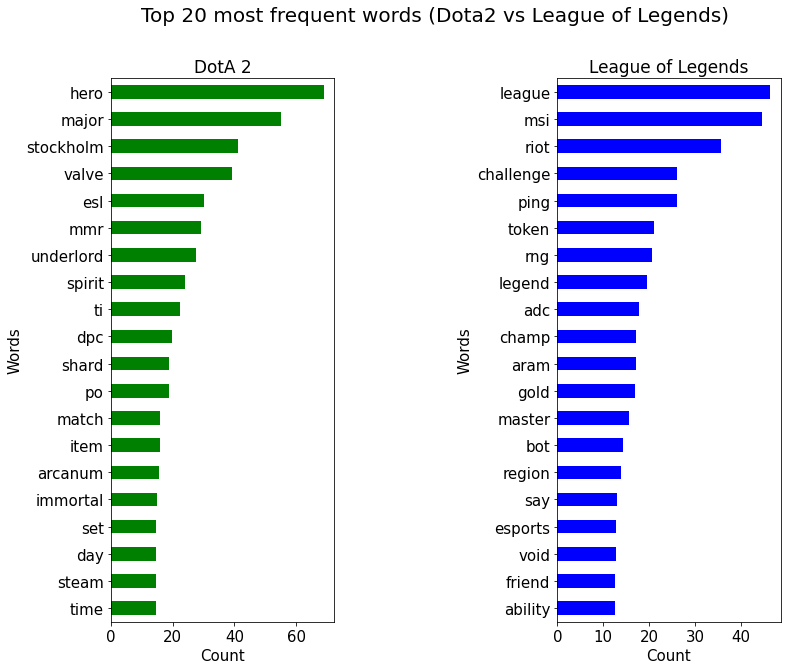

In [521]:
#TFidf Vectorizer with 1-gram
tfidf_vect = TfidfVectorizer(ngram_range=(1,1))

dota_onegram_tfidfvect_lem_df = pd.DataFrame(tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= tfidf_vect.get_feature_names())

lol_onegram_tfidfvect_lem_df = pd.DataFrame(tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= tfidf_vect.get_feature_names())

word_count_plotter(dota_onegram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), lol_onegram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent words (Dota2 vs League of Legends)")

By using TF-IDF vectorizer, comparing to CountVectorizer, below are a few observations:
- Similar observations are observed. Dota2 subreddit still centers around tournament talks
- However, there are some topics with more weightage that are more discussed, e.g. arcanum and immortal which are the items rarity
- League of legends community still discusses about gameplay, ability and strategies

#### <font color = 'Maroon'> Visualise Frequently Occuring Words  - (TFIDF - 2 grams)

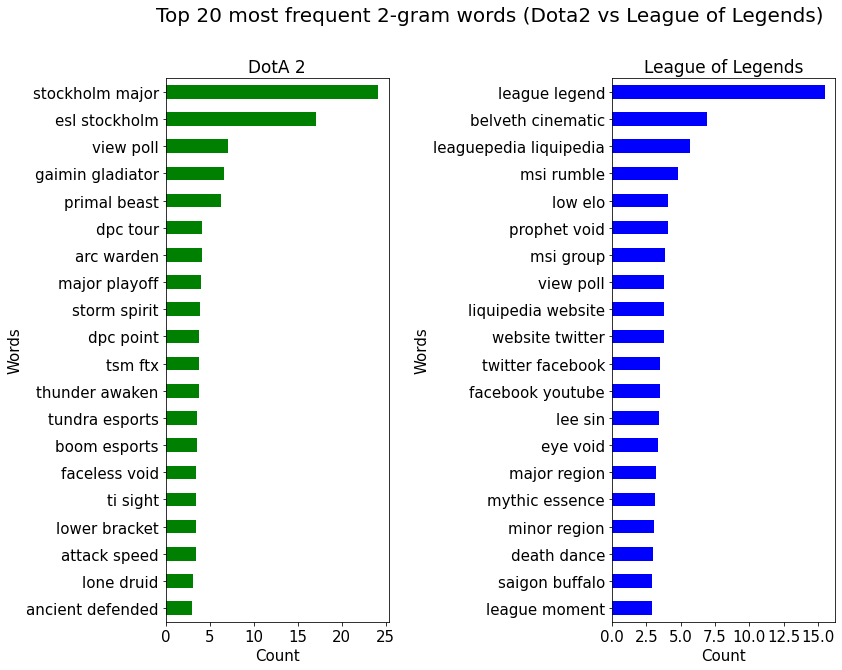

In [523]:
#TFidf Vectorizer with 2-grams
twogram_tfidf_vect = TfidfVectorizer(ngram_range=(2,2))

dota_twogram_tfidfvect_lem_df = pd.DataFrame(twogram_tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'DotA2']['title_selftext_lemmed_joined']).todense(), columns= twogram_tfidf_vect.get_feature_names())

lol_twogram_tfidfvect_lem_df = pd.DataFrame(twogram_tfidf_vect.fit_transform(dota_lol_df[dota_lol_df['subreddit'] == 'leagueoflegends']['title_selftext_lemmed_joined']).todense(), columns= twogram_tfidf_vect.get_feature_names())

word_count_plotter(dota_twogram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), lol_twogram_tfidfvect_lem_df.sum().sort_values(ascending=True).tail(20), "Top 20 most frequent 2-gram words (Dota2 vs League of Legends)")

In [524]:
dota_lol_df.shape

(6106, 15)

For TFIDF Vectorizer 2-grams method, observed same conclusions as DotA2 subreddit talks more about tournaments. However, there are more emphasis on heroes name observed, e.g. arc warden, faceless void, lone druid, etc instead of esports teams as shown in Count Vectorizer. This is due to popular team names that can be the same accross Dota 2 and League of Legends which potentially reduce the importance of team names.


For League of Legends subreddit, there are also new keywords with more weightage occurs for heroes name, notably Prophet Void, Eye Void, Lee Sin.
Additional tournament jargons are also in the list, e.g. Saigon Buffalo (team name) and MSI rumble (tournament name)

All in all TF-IDF factorizer generally emphasises more on stronger features found from each of the subreddit.

For Dota2, they are items rarity and hero names

For League of Legends, they are LOL tournament jargons and hero names

### <font color = 'Maroon'> NLP Model Work

In [525]:
#Convert target variable to 0 for DotA2 and 1 for League of Legends
dota_lol_df['target'] = dota_lol_df['subreddit'].map({'DotA2': 0, 'leagueoflegends': 1})

In [526]:
dota_lol_df['selftext_title'] = dota_lol_df['selftext'] + dota_lol_df['title']

#### <font color = 'Maroon'> Baseline Model

Measuring efficacy of baseline model by predicting the dataset based on the most recurring class

In [527]:
X = dota_lol_df['title_selftext_lemmed_joined']
y = dota_lol_df['target']

In [528]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [529]:
y.value_counts(normalize=True)

0    0.586309
1    0.413691
Name: target, dtype: float64

DotA2 class has 59% chance of accuracy prediction while League of Legends have 41% accuracy prediction 

### <font color = 'Maroon'> Establishing Pipelines For Model Prediction

#### <font color = 'Maroon'> Count Vectorizer (Transformer) -  Logistic Regression (Estimator)   

In [530]:
# Define a pipeline
pipe = Pipeline([('cvec', CountVectorizer()),('lr', LogisticRegression())])

# Define the pipeline parameter
pipe_params = {
    'cvec__max_df':[.85],
    'cvec__min_df':[2],
    'cvec__max_features':[2_000, 3_000, 4_000],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'lr__C': np.logspace(-2, 2, 50),
    'lr__solver': ['liblinear']}

# Instantiate gridsearch instance
gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs = -1, verbose=1)

In [531]:
print(dota_onegram_vect_lem_df.shape)
print(lol_onegram_vect_lem_df.shape)

(3580, 10483)
(2526, 12302)


In [532]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.6min finished


95.20899152755737


In [538]:
#Get metrics in each of the model

def roc_auc_plotter(model, X_test, y_test):
    y_predd = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test,  y_predd)
    auc = roc_auc_score(y_test, y_predd)
    plt.plot(fpr,tpr,label="data, auc=" + str(round(auc,4)))
    plt.title("ROC Curve")
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.plot(["0", "1"], ["0", "1"], label='baseline', linestyle='--')
    plt.legend(loc=4)
    plt.show()
    
    return auc
                    
def model_metric(model, X_train, y_train, X_test, y_test):
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds_test).ravel()
    
    metrics_dict = {'train_accuracy_score' : accuracy_score(y_train, preds_train),
                    'test_accuracy_score'  : accuracy_score(y_test, preds_test),
                    'roc_score' : roc_auc_score(y_test, preds_test),
                    'recall_score' : recall_score(y_test, preds_test),
                    'precision_score' : precision_score(y_test, preds_test),
                    'f1_score' : f1_score(y_test, preds_test),
                    'cross_val_score' : model.best_score_,
                    'sensitivity': tp / (tp + fn),
                    'specificity': tn / (tn + fp)}
    
    print(f"Best Parameters: \n{model.best_params_}\n")
    print(f"F1 Score: \n{metrics_dict['f1_score']}\n")
    print(f"Cross Validation Score: \n{metrics_dict['cross_val_score']}\n")
    print(f"Precision: \n{metrics_dict['precision_score']}\n")
    print(f"Recall: \n{metrics_dict['recall_score']}\n")
    print(f"Sensitivity: \n{metrics_dict['sensitivity']}\n")
    print(f"Specificity: \n{metrics_dict['specificity']}\n")
    print(f"Test ROC-AUC Score: \n{metrics_dict['roc_score']}\n")
    print(f"Train Accuracy Score: \n{metrics_dict['train_accuracy_score']}\n")
    print(f"Test Accuracy Score: \n{metrics_dict['test_accuracy_score']}\n")
    
    plt.figure(figsize=(4,4));
    auc = roc_auc_plotter(model, X_test, y_test);
    plt.show();
    
    plt.figure(figsize=(12,12));
    cf = plot_confusion_matrix(model, X_test, y_test,display_labels=['DotA2', 'leagueoflegends'],  cmap=plt.cm.Blues)
    plt.show();

    return metrics_dict

# Get words importance based on coefficients of the logistic regression model
def get_important_features_lr(vectoriser, estimator):
    feature_names = pd.DataFrame(vectoriser.get_feature_names(), columns=['feature_name'])    
    
    coef_df = pd.DataFrame(estimator.coef_)
    coef_df = coef_df.T
    
    coef_df = pd.concat([coef_df, feature_names], axis=1)    
    coef_df = coef_df.rename(columns={0:'Coefficient_Value'})    
        
    return coef_df.sort_values(by='Coefficient_Value', ascending=True).head(20), coef_df.sort_values(by='Coefficient_Value', ascending=False).head(20)

# plot most important words passed in the two datasets
def plot_important_words(df_coef1, df_coef2, title=""):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title, y=0.98, fontsize =20)

    plot1 = df_coef1.sort_values(by='Coefficient_Value', ascending=False)[:20].plot(kind='barh', y='Coefficient_Value', x='feature_name', ax=axes[0], figsize=(12,10),fontsize=15, color='green');
    plot1.set_xlabel('Importance', fontsize=15)
    plot1.set_ylabel('Words', fontsize=15)
    plot1.set_title('DotA2', fontsize=17)
    plot1.get_legend().remove()
    
    plot2 = df_coef2.sort_values(by='Coefficient_Value', ascending=True)[:20].plot(kind='barh', y='Coefficient_Value', x='feature_name', fontsize=15,ax=axes[1], figsize=(12,10), color='blue');

    plot2.set_xlabel('Importance', fontsize=15)
    plot2.set_ylabel('Words', fontsize=15)
    plot2.set_title('leagueoflegends', fontsize=17)
    plot2.get_legend().remove()

    plt.subplots_adjust(wspace=1)
    plt.show()

Best Parameters: 
{'cvec__max_df': 0.85, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'lr__C': 1.0985411419875584, 'lr__solver': 'liblinear'}

F1 Score: 
0.8349928876244666

Cross Validation Score: 
0.8792744155470643

Precision: 
0.9058641975308642

Recall: 
0.7744063324538258

Sensitivity: 
0.7744063324538258

Specificity: 
0.9432029795158287

Test ROC-AUC Score: 
0.8588046559848272

Train Accuracy Score: 
0.972391202620496

Test Accuracy Score: 
0.8733624454148472



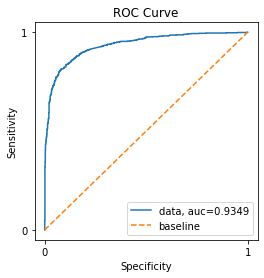

<Figure size 864x864 with 0 Axes>

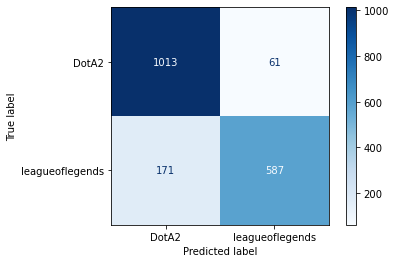

{'train_accuracy_score': 0.972391202620496,
 'test_accuracy_score': 0.8733624454148472,
 'roc_score': 0.8588046559848272,
 'recall_score': 0.7744063324538258,
 'precision_score': 0.9058641975308642,
 'f1_score': 0.8349928876244666,
 'cross_val_score': 0.8792744155470643,
 'sensitivity': 0.7744063324538258,
 'specificity': 0.9432029795158287}

In [539]:
model_metric(gs, X_train, y_train, X_test, y_test)

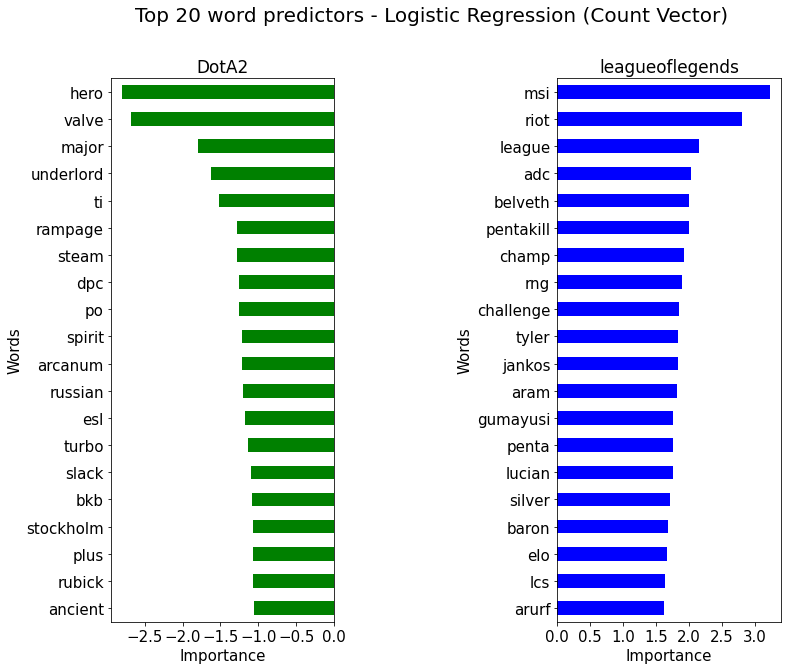

In [540]:
#Top 20 predictors
dota_corr_df, lol_corr_df = get_important_features_lr(gs.best_estimator_.named_steps.cvec, gs.best_estimator_.named_steps.lr)
plot_important_words(dota_corr_df, lol_corr_df, title="Top 20 word predictors - Logistic Regression (Count Vector) ")

#### <font color = 'Maroon'> TF-IDF (Transformer) -  Logistic Regression (Estimator)   

In [541]:
# Define a pipeline
pipe2 = Pipeline([('tfidf', TfidfVectorizer()),('lr', LogisticRegression())])

# Define the pipeline parameter
pipe_params2 = {
    'tfidf__max_df':[.9],
    'tfidf__min_df':[1],
    'tfidf__max_features':[2_000, 3_000, 4_000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__stop_words': [None, 'english'],
    'lr__C': np.logspace(-2, 2, 50),
    'lr__solver': ['liblinear']}

# Instantiate gridsearch instance
gs_tvec = GridSearchCV(pipe2, pipe_params2, cv=5, n_jobs = -1,verbose=1)

In [542]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs_tvec.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.4min


182.6856029033661


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.0min finished


Best Parameters: 
{'lr__C': 8.68511373751352, 'lr__solver': 'liblinear', 'tfidf__max_df': 0.9, 'tfidf__max_features': 4000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}

F1 Score: 
0.8322894919972164

Cross Validation Score: 
0.8869945355191258

Precision: 
0.8807069219440353

Recall: 
0.7889182058047494

Sensitivity: 
0.7889182058047494

Specificity: 
0.9245810055865922

Test ROC-AUC Score: 
0.8567496056956708

Train Accuracy Score: 
0.9892372484791764

Test Accuracy Score: 
0.8684497816593887



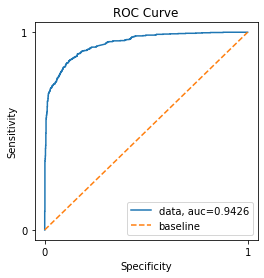

<Figure size 864x864 with 0 Axes>

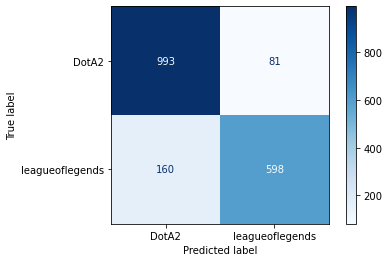

{'train_accuracy_score': 0.9892372484791764,
 'test_accuracy_score': 0.8684497816593887,
 'roc_score': 0.8567496056956708,
 'recall_score': 0.7889182058047494,
 'precision_score': 0.8807069219440353,
 'f1_score': 0.8322894919972164,
 'cross_val_score': 0.8869945355191258,
 'sensitivity': 0.7889182058047494,
 'specificity': 0.9245810055865922}

In [543]:
model_metric(gs_tvec, X_train, y_train, X_test, y_test)

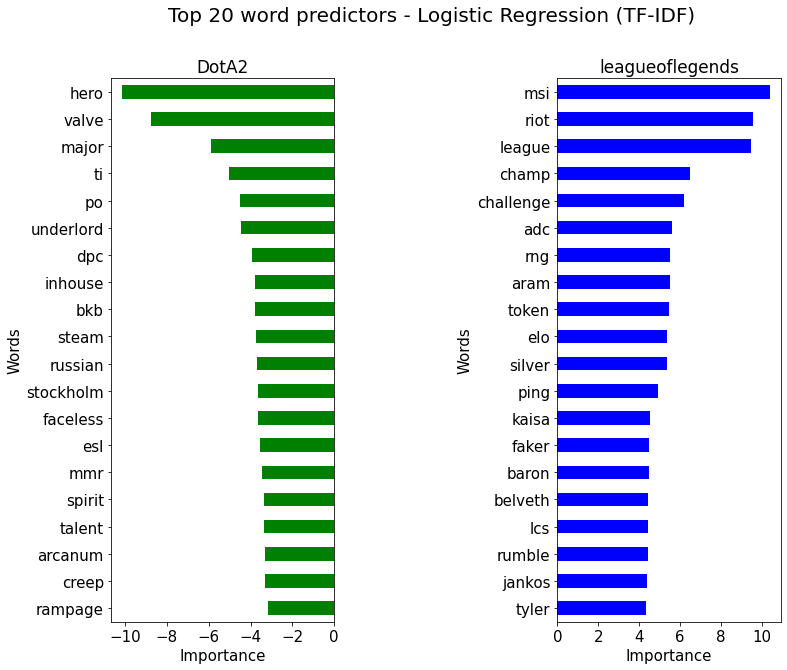

In [544]:
#Top 20 word predictors
dota_corr_df, lol_corr_df = get_important_features_lr(gs_tvec.best_estimator_.named_steps.tfidf, gs_tvec.best_estimator_.named_steps.lr)
plot_important_words(dota_corr_df, lol_corr_df, title="Top 20 word predictors - Logistic Regression (TF-IDF) ")

#### <font color = 'Maroon'> Count Vectorizer (Transformer) -  Multinomial Naive Bayes (Estimator)   

In [545]:
# Define a pipeline
pipe3 = Pipeline([('cvec', CountVectorizer()),('nb', MultinomialNB())])

# Define the pipeline parameter
pipe_params3 = {
    'cvec__max_df':[.85,.9],
    'cvec__min_df':[2],
    'cvec__max_features':[5_000, 6_000, 7_000, 8_000],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha' : [0.6, 0.8, 1],
    'nb__fit_prior': [True, False]}

# Instantiate gridsearch instance
gs_cvec_nb = GridSearchCV(pipe3, pipe_params3, n_jobs = -1, cv=5, verbose=1, refit = 'AUC')

In [546]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs_cvec_nb.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.7s


27.5190486907959


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   27.3s finished


Best Parameters: 
{'cvec__max_df': 0.85, 'cvec__max_features': 7000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 1, 'nb__fit_prior': True}

F1 Score: 
0.8631578947368421

Cross Validation Score: 
0.8933078598134682

Precision: 
0.8608923884514436

Recall: 
0.8654353562005277

Sensitivity: 
0.8654353562005277

Specificity: 
0.9013035381750466

Test ROC-AUC Score: 
0.8833694471877871

Train Accuracy Score: 
0.9443144595226953

Test Accuracy Score: 
0.8864628820960698



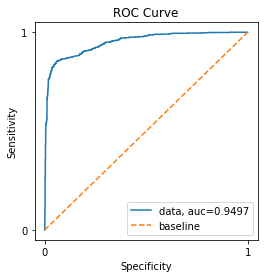

<Figure size 864x864 with 0 Axes>

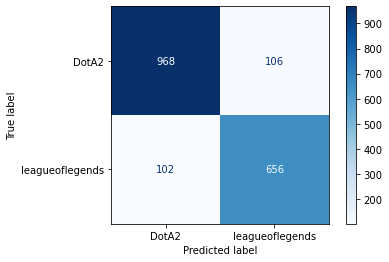

{'train_accuracy_score': 0.9443144595226953,
 'test_accuracy_score': 0.8864628820960698,
 'roc_score': 0.8833694471877871,
 'recall_score': 0.8654353562005277,
 'precision_score': 0.8608923884514436,
 'f1_score': 0.8631578947368421,
 'cross_val_score': 0.8933078598134682,
 'sensitivity': 0.8654353562005277,
 'specificity': 0.9013035381750466}

In [547]:
model_metric(gs_cvec_nb, X_train, y_train, X_test, y_test)

In [561]:
def get_important_features_nb(vectoriser, estimator):
    feature_names = pd.DataFrame(vectoriser.get_feature_names(), columns=['feature_name'])    
    
    coef_df = pd.DataFrame(estimator.feature_log_prob_[1,:] - estimator.feature_log_prob_[0, :])
    
    coef_df = pd.concat([coef_df, feature_names], axis=1)    
    coef_df = coef_df.rename(columns={0:'Coefficient_Value'})    
        
    return coef_df.sort_values(by='Coefficient_Value', ascending=True).head(20), coef_df.sort_values(by='Coefficient_Value', ascending=False).head(20)

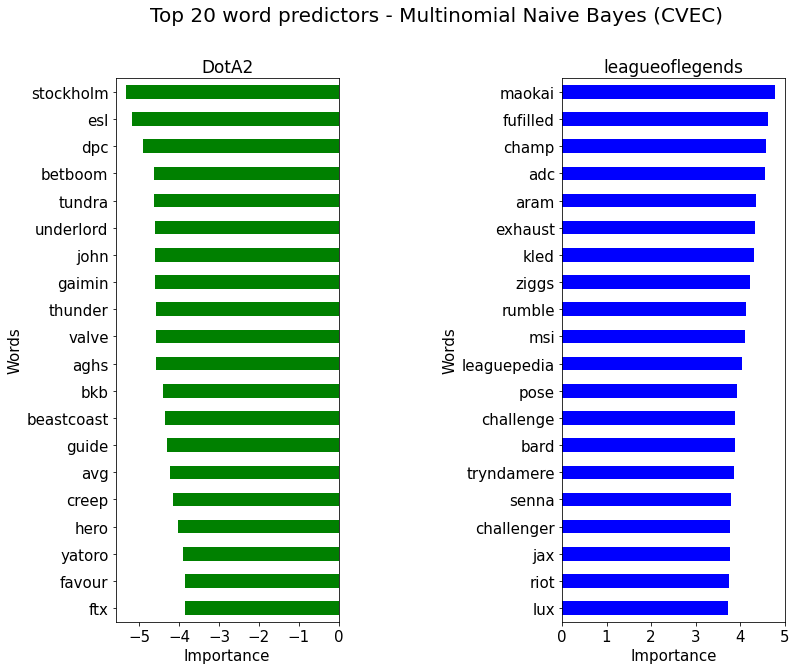

In [563]:
#Top 20 word predictors
dota_corrr_df, lol_corrr_df = get_important_features_nb(gs_cvec_nb.best_estimator_.named_steps.cvec, gs_cvec_nb.best_estimator_.named_steps.nb)
plot_important_words(dota_corrr_df, lol_corrr_df, title="Top 20 word predictors - Multinomial Naive Bayes (CVEC) ")

#### <font color = 'Maroon'> TFIDF (Transformer) -  Multinomial Naive Bayes (Estimator)   

In [565]:
# Define a pipeline
pipe4 = Pipeline([('tfidf', TfidfVectorizer()),('nb', MultinomialNB())])

# Define the pipeline parameter
pipe_params4 = {
    'tfidf__max_df':[.85,.9],
    'tfidf__min_df':[1],
    'tfidf__max_features':[2_000, 3_000, 4_000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__stop_words': [None, 'english'],
    'nb__alpha' : [0.6, 0.8, 1],
    'nb__fit_prior': [True, False]}

# Instantiate gridsearch instance
gs_tvec_nb = GridSearchCV(pipe4, pipe_params4,n_jobs = -1, cv=5, verbose=1)

In [566]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs_tvec_nb.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.2min finished


70.37544393539429


Best Parameters: 
{'nb__alpha': 0.8, 'nb__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}

F1 Score: 
0.8563611491108071

Cross Validation Score: 
0.8937776134324883

Precision: 
0.8892045454545454

Recall: 
0.8258575197889182

Sensitivity: 
0.8258575197889182

Specificity: 
0.9273743016759777

Test ROC-AUC Score: 
0.8766159107324479

Train Accuracy Score: 
0.9541413196069256

Test Accuracy Score: 
0.8853711790393013



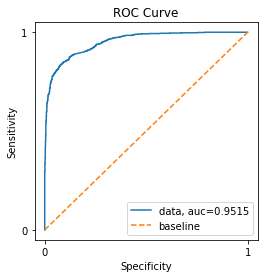

<Figure size 864x864 with 0 Axes>

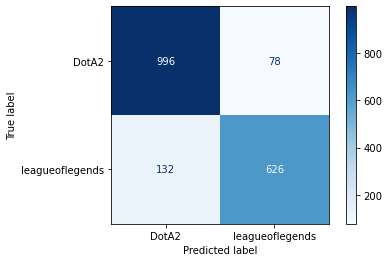

{'train_accuracy_score': 0.9541413196069256,
 'test_accuracy_score': 0.8853711790393013,
 'roc_score': 0.8766159107324479,
 'recall_score': 0.8258575197889182,
 'precision_score': 0.8892045454545454,
 'f1_score': 0.8563611491108071,
 'cross_val_score': 0.8937776134324883,
 'sensitivity': 0.8258575197889182,
 'specificity': 0.9273743016759777}

In [567]:
model_metric(gs_tvec_nb, X_train, y_train, X_test, y_test)

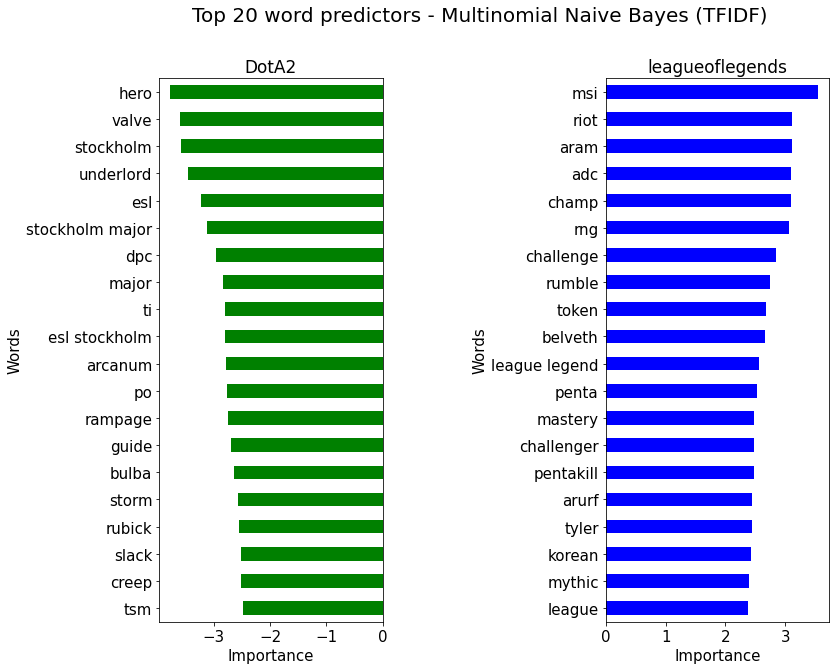

In [569]:
#Top 20 word predictors
dota_corrr_df, lol_corrr_df = get_important_features_nb(gs_tvec_nb.best_estimator_.named_steps.tfidf, gs_tvec_nb.best_estimator_.named_steps.nb)
plot_important_words(dota_corrr_df, lol_corrr_df, title="Top 20 word predictors - Multinomial Naive Bayes (TFIDF) ")

#### <font color = 'Maroon'> Count Vectorizer (Transformer) -  K-Nearest Neighbour (Estimator)   

In [570]:
# Define a pipeline
pipe5 = Pipeline([('cvec', CountVectorizer()),('knn', KNeighborsClassifier())])

# Define the pipeline parameter
pipe_params5 = {
    'cvec__max_df':[.85,.9],
    'cvec__min_df':[2],
    'cvec__max_features':[2_000, 3_000, 4_000],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'knn__n_neighbors' : [4,8,12,16,20,24,28,32],
    'knn__leaf_size': [30,35,40]
}

# Instantiate gridsearch instance
gs_cvec_knn = GridSearchCV(pipe5, pipe_params5,n_jobs = -1, cv=5, verbose=1)

In [571]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs_cvec_knn.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.1min finished


128.31565642356873


Best Parameters: 
{'cvec__max_df': 0.85, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'knn__leaf_size': 30, 'knn__n_neighbors': 4}

F1 Score: 
0.5047438330170778

Cross Validation Score: 
0.7075379706095841

Precision: 
0.8986486486486487

Recall: 
0.35092348284960423

Sensitivity: 
0.35092348284960423

Specificity: 
0.9720670391061452

Test ROC-AUC Score: 
0.6614952609778747

Train Accuracy Score: 
0.770004679457183

Test Accuracy Score: 
0.7150655021834061



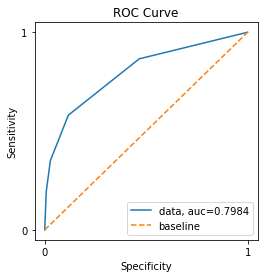

<Figure size 864x864 with 0 Axes>

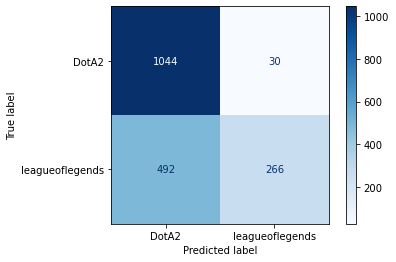

{'train_accuracy_score': 0.770004679457183,
 'test_accuracy_score': 0.7150655021834061,
 'roc_score': 0.6614952609778747,
 'recall_score': 0.35092348284960423,
 'precision_score': 0.8986486486486487,
 'f1_score': 0.5047438330170778,
 'cross_val_score': 0.7075379706095841,
 'sensitivity': 0.35092348284960423,
 'specificity': 0.9720670391061452}

In [572]:
model_metric(gs_cvec_knn, X_train, y_train, X_test, y_test)

#### <font color = 'Maroon'> TFIDF (Transformer) -  K-Nearest Neighbour (Estimator)   

In [573]:
# Define a pipeline
pipe6 = Pipeline([('tfidf', TfidfVectorizer()),('knn', KNeighborsClassifier())])

# Define the pipeline parameter
pipe_params6 = {
    'tfidf__max_df':[.85,.9],
    'tfidf__min_df':[1],
    'tfidf__max_features':[2_000, 3_000, 4_000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__stop_words': [None, 'english'],
    'knn__n_neighbors' : [4,6,8,10,12,14,16,20,24,28,32],
    'knn__leaf_size': [30,35,40]}

# Instantiate gridsearch instance
gs_tfidf_knn = GridSearchCV(pipe6, pipe_params6, n_jobs = -1, cv=5, verbose=1)

In [574]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs_tfidf_knn.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3960 out of 3960 | elapsed:  5.7min finished


342.5750608444214


Best Parameters: 
{'knn__leaf_size': 30, 'knn__n_neighbors': 4, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}

F1 Score: 
0.3043478260869565

Cross Validation Score: 
0.6357020967719846

Precision: 
0.8641975308641975

Recall: 
0.18469656992084432

Sensitivity: 
0.18469656992084432

Specificity: 
0.9795158286778398

Test ROC-AUC Score: 
0.582106199299342

Train Accuracy Score: 
0.7042583060364997

Test Accuracy Score: 
0.6506550218340611



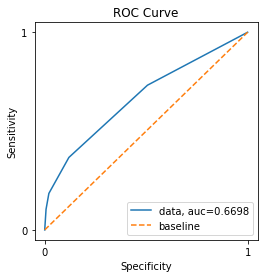

<Figure size 864x864 with 0 Axes>

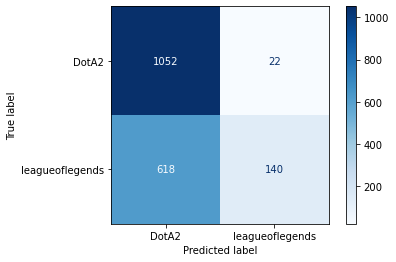

{'train_accuracy_score': 0.7042583060364997,
 'test_accuracy_score': 0.6506550218340611,
 'roc_score': 0.582106199299342,
 'recall_score': 0.18469656992084432,
 'precision_score': 0.8641975308641975,
 'f1_score': 0.3043478260869565,
 'cross_val_score': 0.6357020967719846,
 'sensitivity': 0.18469656992084432,
 'specificity': 0.9795158286778398}

In [575]:
model_metric(gs_tfidf_knn, X_train, y_train, X_test, y_test)

#### <font color = 'Maroon'> Count Vectorizer (Transformer) -  Random Forest (Estimator)

In [576]:
# Define a pipeline
pipe7 = Pipeline([('cvec', CountVectorizer()),('rf', RandomForestClassifier())])

# Define the pipeline parameter
pipe_params7 = {
    'cvec__max_df':[.85,.9],
    'cvec__min_df':[2],
    'cvec__max_features':[2_000, 3_000, 4_000],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators' : [150, 200, 250],  
    'rf__ccp_alpha': [0, 0.01, 0.1],
}

# Instantiate gridsearch instance
gs_cvec_rf = GridSearchCV(pipe7, pipe_params7,n_jobs = -1, cv=5, verbose=1, refit='AUC')

In [577]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs_cvec_rf.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.7min finished


345.7502706050873


Best Parameters: 
{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'rf__ccp_alpha': 0, 'rf__n_estimators': 250}

F1 Score: 
0.828513786146604

Cross Validation Score: 
0.8650015749756907

Precision: 
0.8449931412894376

Recall: 
0.8126649076517151

Sensitivity: 
0.8126649076517151

Specificity: 
0.8947858472998138

Test ROC-AUC Score: 
0.8537253774757644

Train Accuracy Score: 
0.9927468413664015

Test Accuracy Score: 
0.8608078602620087



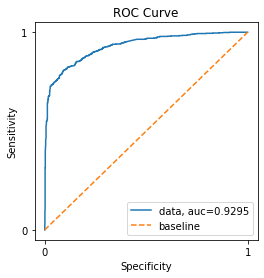

<Figure size 864x864 with 0 Axes>

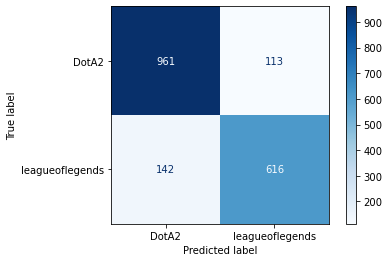

{'train_accuracy_score': 0.9927468413664015,
 'test_accuracy_score': 0.8608078602620087,
 'roc_score': 0.8537253774757644,
 'recall_score': 0.8126649076517151,
 'precision_score': 0.8449931412894376,
 'f1_score': 0.828513786146604,
 'cross_val_score': 0.8650015749756907,
 'sensitivity': 0.8126649076517151,
 'specificity': 0.8947858472998138}

In [578]:
model_metric(gs_cvec_rf, X_train, y_train, X_test, y_test)

In [579]:
#fig, ax = plt.subplots()
rf_cvec_features = pd.DataFrame(gs_cvec_rf.best_estimator_.named_steps.cvec.get_feature_names(), columns =['feature_names'])

cvec_feature_importances_df =pd.DataFrame(gs_cvec_rf.best_estimator_._final_estimator.feature_importances_)
 
                                
cvec_feature_importances_df = pd.concat([cvec_feature_importances_df, rf_cvec_features], axis = 1)
cvec_feature_importances_df = cvec_feature_importances_df.rename(columns={0:'Coefficient_Value'})                                
                                

Text(0.5, 1.0, 'Feature Importance (CVEC - RF)')

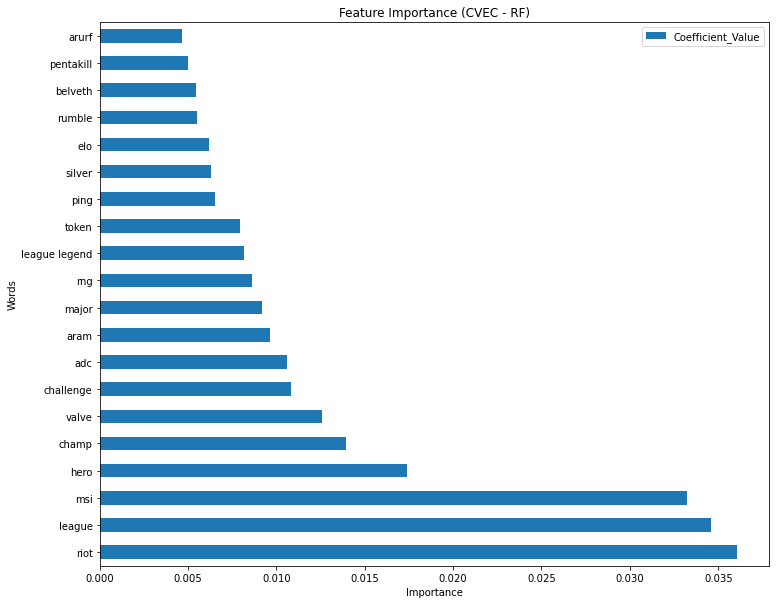

In [580]:
plot_cvec_rf = cvec_feature_importances_df.sort_values(by='Coefficient_Value', ascending= False)[:20].plot(kind='barh', y='Coefficient_Value', x='feature_names', figsize= (12,10))
plot_cvec_rf.set_xlabel('Importance')
plot_cvec_rf.set_ylabel('Words')
plot_cvec_rf.set_title('Feature Importance (CVEC - RF)')

#### <font color = 'Maroon'> TFIDF (Transformer) -  Random Forest (Estimator)

In [581]:
# Define a pipeline
pipe8 = Pipeline([('tfidf', CountVectorizer()),('rf', RandomForestClassifier())])

# Define the pipeline parameter
pipe_params8 = {
    'tfidf__max_df':[.85,.9],
    'tfidf__min_df':[2],
    'tfidf__max_features':[2_000, 3_000, 4_000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__stop_words': [None, 'english'],
    'rf__n_estimators' : [150, 200, 250],  
    'rf__ccp_alpha': [0, 0.01, 0.1],
}

# Instantiate gridsearch instance
gs_tfidf_rf = GridSearchCV(pipe8, pipe_params8,n_jobs = -1, cv=5, verbose=1, refit='AUC')

In [582]:
# Fit the model and print the time taken to fit the model
start_time = time.time()
gs_tfidf_rf.fit(X_train, y_train)
print("{}".format(time.time() - start_time))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 11.1min finished


670.5149703025818


Best Parameters: 
{'rf__ccp_alpha': 0, 'rf__n_estimators': 200, 'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}

F1 Score: 
0.8279132791327914

Cross Validation Score: 
0.8657033293616555

Precision: 
0.850974930362117

Recall: 
0.8060686015831134

Sensitivity: 
0.8060686015831134

Specificity: 
0.9003724394785847

Test ROC-AUC Score: 
0.853220520530849

Train Accuracy Score: 
0.9913430042115114

Test Accuracy Score: 
0.861353711790393



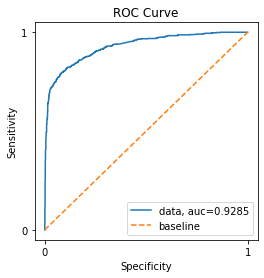

<Figure size 864x864 with 0 Axes>

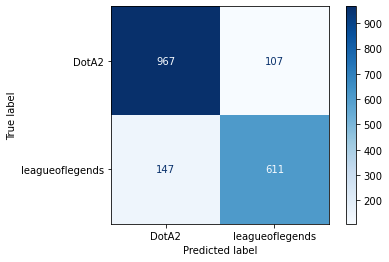

{'train_accuracy_score': 0.9913430042115114,
 'test_accuracy_score': 0.861353711790393,
 'roc_score': 0.853220520530849,
 'recall_score': 0.8060686015831134,
 'precision_score': 0.850974930362117,
 'f1_score': 0.8279132791327914,
 'cross_val_score': 0.8657033293616555,
 'sensitivity': 0.8060686015831134,
 'specificity': 0.9003724394785847}

In [583]:
model_metric(gs_tfidf_rf, X_train, y_train, X_test, y_test)

In [584]:
rf_tfidf_features = pd.DataFrame(gs_tfidf_rf.best_estimator_.named_steps.tfidf.get_feature_names(), columns =['feature_names'])

tfidf_feature_importances_df =pd.DataFrame(gs_tfidf_rf.best_estimator_._final_estimator.feature_importances_)
 
                                
tfidf_feature_importances_df = pd.concat([tfidf_feature_importances_df, rf_tfidf_features], axis = 1)
tfidf_feature_importances_df = tfidf_feature_importances_df.rename(columns={0:'Coefficient_Value'})  

Text(0.5, 1.0, 'Feature Importance (TFIDF - RF)')

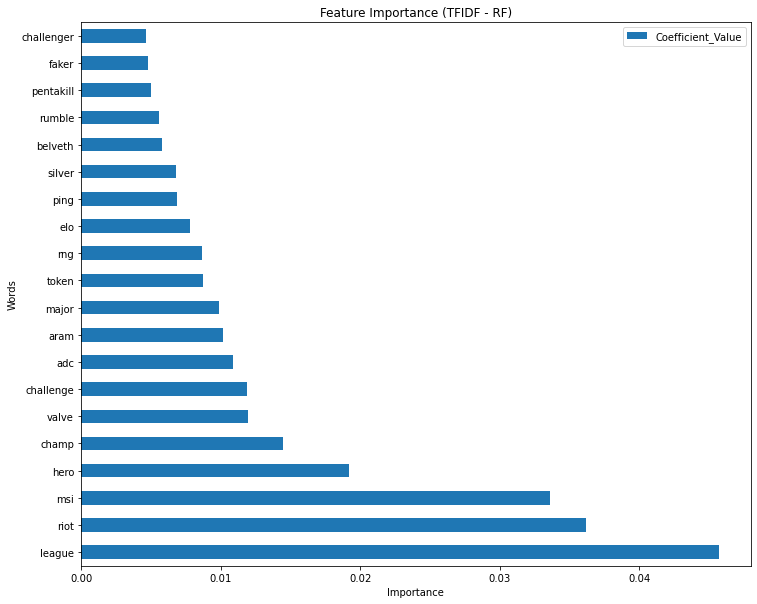

In [587]:
plot_tfidf_rf = tfidf_feature_importances_df.sort_values(by='Coefficient_Value', ascending= False)[:20].plot(kind='barh', y='Coefficient_Value', x='feature_names', figsize= (12,10))
plot_tfidf_rf.set_xlabel('Importance')
plot_tfidf_rf.set_ylabel('Words')
plot_tfidf_rf.set_title('Feature Importance (TFIDF - RF)')

### <font color = 'Maroon'> Best Model Selection

Below table is the summary of training and testing data accuracy for each of the classification machine model

|Models| Training Accuracy Data|Testing Accuracy Data|
|---|:-:|:-:|
|Count Vectorizer + Logistic Regression|97.3%|87.3%|
|TF-IDF Vectorizer + Logistic Regression|98.9%|86.9%|
|Count Vectorizer + Multinomial Naive Bayes |94.4%|88.6%|
|TF-IDF Vectorizer + Multinomial Naive Bayes|95.4%|88.5%|
|Count Vectorizer + K-Nearest Neighbor|77%|71.5%|
|TF-IDF Vectorizer + K-Nearest Neighbor|70.4%|65%|
|Count Vectorizer + Random Forest|99.3%|86.1%|
|TF-IDF Vectorizer + Random Forest|99.1%|86.1%|

All the machine learning models have a better accuracy than the base model (~50%). Below are the models sorted by testing accuracy data:
- Multinomial Bayes
- Logistic Regression
- Random Forest
- K-Nearest Neighbor

It can be observed that all models except K-Nearest Neighbor have high testing accuracy with Multinomial Bayes as the top estimator model based on bias and variance. Multinomial Naive Bayes is one of the most commonly used techniques for NLP. With the prediction based on the probability of the classification based on the number of words occurence, it is more natural to predict model with texts. 

On the other hand, K-Nearest Neighbor has the lowest accuracy. This could be due to the less nature compatibility of K-nearest neighbor with NLP/text classification. Also, model hyperparameter tuning on the number of neighbors could affect the accuracy of the model. In addition, it does not generate coefficient values that can outline feature importance. Therefore, K-nearest neighbor is not recommended.

As such, Multinomial Naive Bayes is picked as the model for machine learning. For the vectorizer, both vectorizers (Count Vectorizer and TF-IDF Vectorizer has similar testing accuracy. However, as Count Vectorizer is slightly better, count vectorizer is picked instead. So final model will be **Count Vectorizer - Multinomial Naive Bayes**

Observations for Count Vectorizer - Multinomial Naive Bayes model (*Top 20 word predictors can be referred to the charts in the previous modelling section*):
- Tournament related events (Stockholm, ESL, DPC) are very strong indicator that a post belongs to DotA2 subreddit. It is almost as important as the hero (Maokai) in League of Legends.
- Furthermore, DotA2 team names (Gaimin, Betboom, Tundra, BeastCoast,  Yatoro and FTX) are also important keywords for DotA2 subreddit
- Notably also observed that only 1 hero (Underlord) is a key predictor for DotA2 while there are more heroes (Kled, Ziggs, Bard, Tryndamere, Jax, Lux and Senna) are identified as key predictors for League of Legends

All in all, for top key predictors, tournament-related jargons and terms are the most important key predictors for DotA2. Meanwhile, heroes/ characters are the most important key predictors for League of Legends.

For other score metrics, precision score is as high as 86%. Recall score is as high as 86.5%. Sensitivity is as high as 86.5% and Specificity is as high as 90.1%. Since precision matters most for correctly classifying the subreddit posts, 86% is a decent figure.

ROC score is as high as 88.3%, indicating a high sensitivity as specificity is low. Also, sensitivity remains high as specificity is higher. This is a good indicator to correctly predicting DotA2 and League of Legends.

Other advantage of using NB classifier is also the runtime of the model, with only 27 secs required as compared to other models that require 3 - 11 mins

### <font color = 'Maroon'> Summary & Conclusion

Project has achieved its main objective through the following:
- Data was scraped through PushShift API using request library
- Successfully trained NLP models for classifiying binary subreddit posts

After data was scraped with PushShift API, data verification was done to ensure enough texts (selftext + title) to be analysed and proportion of each subreddit is comparable. Also, only posts that are 'not removed' in the subreddit are picked for NLP modelling.

Subsequently, data cleaning and preprocessing was done through whitespaces, other regexes, punctuations and stop words removal. Afterwards, tokenisation, stemming and lemmatization to convert the words to its base form was also conducted before texts are being vectorised and transformed.

For the EDA and most frequent words, below are a few key observations:

__Count Vectorizer method__

_Dota2_
- Subreddit generally centers around tournaments, as seen from the word Stockholm, referring to ESL one in Stockholm happened 12 May -22 May 2022
- Also, TI(The International) and DPC (Dota Pro Circuit) refer to the top tournaments and placements for top teams
- MMRs are also the top words as people talk about their own ranked matches or pro players rank matches


_League of Legends_
- Subreddit centers around gameplay and game highlights as people talk about ability, challenge, spell , ultimate.
- The community talks a bit of strategy as shown in the word adc (Attack Damage Carry) and bot (Bottom lane)
- Only MSI ( Mid-Season Invitational) competition is in the frequent word, unlike Dota2 with many competitions in the word list

Both games publisher (Valve for Dota2 and Riot for League of Legends) are in the top words list which is expected.

Surprisingly, only a small portion of heroes name from each game are mentioned.
- For Dota2, only 'spirit' is mentioned. However, 'spirit' can refer to 4 heroes e.g. 'Ember Spirit', 'Void Spirit', 'Storm Spirit' , 'Earth Spirit' and 'Spirit Breaker'. Those words will be analysed later in 2-grams vectorizer to see if they are in the list
- For League of Legends, only teemo is mentioned in the list.

__TF-IDF Vectorizer method__

_Dota2_
- Similar observations are observed as compared to count vectorizer. Dota2 subreddit still centers around tournament talks
- However, there are some topics with more weightage that are more discussed e.g. arcanum and immortal which are the items rarity as well as hero names. Team names are no longer in the list as team names could be the same accross Dota2 and League of Legends


_Leauge of Legends_
- League of legends community still discusses about gameplay, ability and strategies
- However, some topics with more weightage occurred e.g. hero names and LOL tournament jargons (Saigon Buffalo and MSI rumble)

For the best model, __Count Vectorizer - Multinomial Bayes__ is used based on the following reasons:
- Provides the best testing accuracy score (88.6%)
- While TF-IDF theoretically results in a better model performance comparing to Count Vectorizer due to its weightage on the presence of each token relative to the frequency of the posts, Count Vectorizer has a faster runtime (27 secs vs 1.2 mins) with similar test accuracy score
- Multinomial Bayes has lower overfitting values compared to other models including logistic regression
- Multinomial Bayes provides interpretibilty in which insights can be easier derived based on the words importance to classify the subreddits

### <font color = 'Maroon'> Limitations & Future Work

There are a few limitations that were noted:
- Extra stop words are hard to be identified in a large scale text dataset. This requires manual identification of stop words removal
- Better data cleaning steps can be introduced to remove heroes names and unique terms in each subreddit to enable a more granular model
- A balance is also needed to ensure non-excessive overlapping words between subreddits
- Faster resources , i.e super computer is preferred to enable a wider range of hyperparameter tuning.

For future work, the team will pull data sources from other groups of sites, i.e. Twitter, Meta and Instagram to enable sources diversification. For better understanding, the team will also check on the misclassified posts and further enhance the accuracy score. In addition, feature additions will also be done in terms of flagging and removing unusual posts (spams, profanities, etc). Also, sentiment analysis feature can be added to provide game developers on real-time insights regarding sentiments of their games. Thus, they can plan and fix their games ahead of time whenever their games start to potray negative sentiments. On the other hand, extra analysis can also be provided to streamers to check what time each game has the highest traffic posts. This could potentially give insights to streamers on the best time to stream as the game community might be most active on that particular time and potentially gaining more views.